## Imports

In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from matplotlib.colors import ListedColormap
from sklearn.metrics.pairwise import cosine_similarity
from scipy.optimize import minimize, rosen, rosen_der
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier


# Data Processing


We start the data analysis by loading in the Train.csv under the data variable, and splitting this into two different datasets: one containing the boolean values of whether a comment has a certain characteristic, and another dataset containing the confidence for their associated boolean values.

We have a quick look at conf_data to validate the shape of this dataset

In [2]:
data = pd.read_csv("corpus/train.csv")
testdata = pd.read_csv("corpus/test.csv")
class_data = data[["antagonise", "condescending", "dismissive", "generalisation", "generalisation_unfair", "hostile", "sarcastic"]]
conf_data = data[['antagonise:confidence', 'condescending:confidence', 'dismissive:confidence','generalisation:confidence', 'generalisation_unfair',
       'generalisation_unfair:confidence','hostile:confidence', 'sarcastic:confidence']]

conf_data

,antagonise:confidence,condescending:confidence,dismissive:confidence,generalisation:confidence,generalisation_unfair,generalisation_unfair:confidence,hostile:confidence,sarcastic:confidence
0,0.5816,0.5816,0.5816,1.0000,0.0,1.0,0.5816,0.8001
1,1.0000,1.0000,1.0000,1.0000,0.0,1.0,1.0000,1.0000
2,1.0000,0.8063,1.0000,1.0000,0.0,1.0,1.0000,0.8063
3,0.7931,0.5959,0.5959,1.0000,0.0,1.0,1.0000,0.6052
4,1.0000,1.0000,1.0000,1.0000,0.0,1.0,1.0000,1.0000
...,...,...,...,...,...,...,...,...
35498,0.8114,0.7888,0.8114,0.6002,0.0,0.0,0.6002,0.6002
35499,1.0000,1.0000,1.0000,1.0000,0.0,1.0,1.0000,1.0000
35500,1.0000,1.0000,1.0000,1.0000,0.0,1.0,1.0000,1.0000
35501,1.0000,1.0000,1.0000,1.0000,0.0,1.0,1.0000,1.0000


### Train/Test split
We now create the datasets for training and testing the model.
For this split, we specifically only use the train.csv dataset for both the train and test sets.
This is because we assume that train.csv is sufficiently large (over 35 thousand rows) to properly train and test our model. Using this train/test allocation, this leaves all other csv datasets (such as test.csv) completely untouched for potential future uses, such as double-checking the skillfulness of a model after it has already been validated using train.csv

In [3]:
target_column = "healthy"


xtrain, xtest, ytrain, ytest = train_test_split(class_data, data[target_column])

### Dumb Classifier
In order to determine in what ballpark we should be looking for our accuracy scores, we quickly determine how accurate it would be to simply say that all comments are healthy

In [4]:
pos_sum = sum(data["healthy"])
print(f"""The total of comments is {len(data)}, of those {pos_sum} are healthy, 
so saying everything is healthy would already result in an accuracy percentage of {pos_sum/ len(data)*100}%""")


The total of comments is 35503, of those 32848 are healthy, 
so saying everything is healthy would already result in an accuracy percentage of 92.52175872461483%


This implies that any model should strive to outperform at least this accuracy score

### Creating plot analysis functions
As additional accuracy measures, we can also include ROC and precision-recall curves. Therefore, we define two functions to plot these curves here.

In [5]:
def roc(model):
    auc_score = roc_auc_score(ytest, model.predict_proba(xtest)[:,1])
    false_positive, true_positive, _ = roc_curve(
    ytest, model.predict_proba(xtest)[:, 1]
    )

    plt.plot(false_positive, true_positive, marker=".", label="Decision Tree")
    plt.plot([[0, 0], [1.0, 1.0]], linestyle="--", label="line")
    plt.title(f"ROC Curve; AUC: {auc_score}")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend
    plt.show()
    
def recall(model):
    good_probs = model.predict_proba(xtest)[:, 1]

    precision, recall, _ = precision_recall_curve(ytest, good_probs)
    auc_score = auc(recall, precision)
    plt.figure()
    plt.plot(recall, precision, marker=".", label="Decision Tree")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title(f"Precision-Recall curve; AUC: {auc_score}")
    plt.show()
    plt.close("all")

# Training and optimizing the models
We will now start training and validating the model using a method of Ensemble learning.
We use a range of different models which we each validate indivually based on their accuracy score, and then we combine all of these models together in a Voting Classifier and determine the accuracy of that voting classifier. The expectation here is that the Voting Classifier should have (one of) the best accuracy scores

For future reproducability, entire process is defined in the classify() function.

In [6]:
def classify(xtrain, xtest,ytrain, ytest, voting="hard"):
    # Add all the estemators/classifiers
    est = [("lr", LogisticRegression()), 
           ("rf", RandomForestClassifier(n_estimators=100)), 
           ("nb", GaussianNB()),
            ("qda", QuadraticDiscriminantAnalysis()),
           ("kn", KNeighborsClassifier()),
           ("mlp", MLPClassifier())
           ]
    voting_clf = VotingClassifier(
        estimators=est,
        voting=voting,
    )
    voting_clf.fit(xtrain, ytrain)

    for _, clf in est:
        clf.fit(xtrain, ytrain)
        y_pred = clf.predict(xtest)
        print(clf.__class__.__name__, accuracy_score(ytest, y_pred))

    # And now we print the voting clf
    y_pred = voting_clf.predict(xtest)
    print(voting_clf.__class__.__name__, accuracy_score(ytest, y_pred))
classify(xtrain, xtest,ytrain, ytest)

LogisticRegression 0.9441189725101397
RandomForestClassifier 0.9443442992338892
GaussianNB 0.912798557908968
QuadraticDiscriminantAnalysis 0.912798557908968
KNeighborsClassifier 0.9445696259576386
MLPClassifier 0.9450202794051374
VotingClassifier 0.9451329427670122


### Discussion of results
The accuracy scores came out approximately as expected, where most models produced an accuracy score slightly higher than the dumb classifier's accuracy of 92.5%. The Voting Classifier specifically was on the high end of the spectrum, with an accuracy score of 94%, which was only beaten by Logistic Regression (94.1%) and MLP Classifier (94.3%).

A possible explanation for the subpar performance of the voting classifier could be the inclusion of the QuadraticDiscriminantAnalysis. This specific classifier has a very low accuracy score (90%) and struggles with colinearity, and could therefore be skewing the quality of our voting classifier. In order to try and improve the voting classifier, we try it again without the inclusion of the QuadraticDiscriminantAnalysis:

In [7]:
def classify(xtrain, xtest,ytrain, ytest, voting="hard"):
    # Add all the estemators/classifiers
    est = [("lr", LogisticRegression()), 
           ("rf", RandomForestClassifier(n_estimators=100)), 
           ("nb", GaussianNB()),
            #("qda", QuadraticDiscriminantAnalysis()),
           ("kn", KNeighborsClassifier()),
           ("mlp", MLPClassifier())
           ]
    voting_clf = VotingClassifier(
        estimators=est,
        voting=voting,
    )
    voting_clf.fit(xtrain, ytrain)

    for _, clf in est:
        clf.fit(xtrain, ytrain)
        y_pred = clf.predict(xtest)
        print(clf.__class__.__name__, accuracy_score(ytest, y_pred))

    # And now we print the voting clf
    y_pred = voting_clf.predict(xtest)
    print(voting_clf.__class__.__name__, accuracy_score(ytest, y_pred))
    if voting == "soft":
        roc(voting_clf)
        recall(voting_clf)
classify(xtrain, xtest,ytrain, ytest)

LogisticRegression 0.9441189725101397
RandomForestClassifier 0.9443442992338892
GaussianNB 0.912798557908968
KNeighborsClassifier 0.9445696259576386
MLPClassifier 0.944794952681388
VotingClassifier 0.944794952681388


# New prediciton accuracy high score: 94.5%
Removing the QuadraticDiscriminantAnalysis has indeed improved the quality of the voting classifier, up to an accuracy of 94.4%. More importantly however, the voting classifier now shows to actually be the most accurate predictor of the entire bunch: proving that Ensemble learning is indeed more effective than each of its composite models individually.

I have also tried other combinations of (removing) specific classifiers such as removing the low-performing GausianNB, but this specific model setup containing a voting classifier of  LogisticRegression, RandomForest, GaussianNB, Kneighbors and MLP has shown to be the most optimal model combination.

In order to determine the most efficient way of voting, we now also include the same setup with soft voting in order to compare accuracy scores.

For soft voting we have also included functions to plot the ROC and Precision-recall curves, so these can be viewed with the soft voting model as well.

## Soft voting and Plots

LogisticRegression 0.9441189725101397
RandomForestClassifier 0.9443442992338892
GaussianNB 0.912798557908968
KNeighborsClassifier 0.9445696259576386
MLPClassifier 0.944794952681388
VotingClassifier 0.9450202794051374


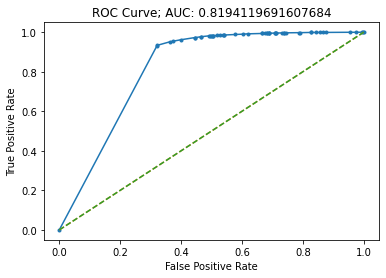

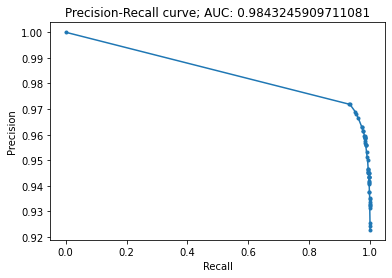

In [8]:
classify(xtrain, xtest,ytrain, ytest, "soft")

Soft voting gives an accuracy of 94.2%, which is lower than the 94.5% obtained by hard voting. Therefore we will continue to use hard voting

## Feature Importance
In order to determine which features are the most important in determining whether a comment is healthy or not, we add some code that represents the feature importance in a random forest classifier

In [41]:
forest = RandomForestClassifier(n_estimators = 100)
forest.fit(xtrain, ytrain)
y_pred = forest.predict(xtest)
importance = forest.feature_importances_

print(f"""the relative importance for the following features are: \n antagonise: {importance[0]} 
 condescending: {importance[1]}
 dismissive: {importance[2]}
 generalisation: {importance[3]}
 generalisation_unfair: {importance[4]}
 hostile: {importance[5]}
 sarcastic: {importance[6]}""")


the relative importance for the following features are: 
 antagonise: 0.4471700374348574 
 condescending: 0.12225456722042005
 dismissive: 0.06783727860656907
 generalisation: 0.023381519822369214
 generalisation_unfair: 0.035927822393692355
 hostile: 0.26652508706773326
 sarcastic: 0.036903687454358784


From these feature importances, it becomes clear that whether a comment is hostile or not has a large influence in whether it is decided to be healthy or not, which makes quite a lot of sense. It also shows that the Gernalisations and Sarcastic features don't influence the healthiness of a comment that much, as they have a relatively low feature importance. Removing some of these unimportant features could provide and additional way to try and improve the accuracy of the model.

# Confidence attempt
We now want to see whether we can include the confidence scores of the boolean values in order to increase our model accuracy.

In order to do this, we create a new dataset called weighted. This dataset represents the probability that a specific characterstic is true for its corresponding comment.
The value in a weighted column is equal to the confidence interval if the classifier == 1, and the value equals 1 - the confidence interval if the classifier == 0.

The intuition behind this is that if we are 60% certain that something is true, we are 1 - 0.6 = 40% certain that it is false. Conversely, if we are 70% certain that something is false, there is a 30% probability that it may be true. The weighted dataset represents this.

In [9]:
np.array(conf_data)
weighted = []
for conf_column, class_column in zip(conf_data, class_data):
    column = []
    for conf, clas in zip(data[conf_column], data[class_column]):
        if clas == 1:
            new = conf
        else: 
            new = 1 - conf
        column.append(new)
    weighted.append(column)
    
    
weightedold = weighted    
weighted = np.array(weighted).T
print(weighted)

[[0.5816 0.5816 0.5816 ... 1.     1.     0.4184]
 [0.     0.     0.     ... 1.     0.     0.    ]
 [0.     0.1937 0.     ... 1.     0.     0.    ]
 ...
 [0.     0.     0.     ... 1.     0.     0.    ]
 [0.     0.     0.     ... 1.     0.     0.    ]
 [0.     0.     0.     ... 1.     0.     0.    ]]


After creating this dataset, we try it out on the optimized voting classifier with both hard and soft voting:

In [10]:
xtrain2, xtest2, ytrain2, ytest2 = train_test_split(weighted, data[target_column])
classify(xtrain2, xtest2,ytrain2, ytest2)

LogisticRegression 0.9436683190626408
RandomForestClassifier 0.9469355565570077
GaussianNB 0.8918431726002704
KNeighborsClassifier 0.9435556557007662
MLPClassifier 0.9473862100045065
VotingClassifier 0.9470482199188823


# New accuracy high-score: 94.7%
Interestingly enough, this creative approach to implementing confidence intervals in the models actually seems to yield results. While the improvement isn't massive, our new weighted dataset can raise the votingclassifier accuracy up to 94.7%, which is slightly higher than what we achieved with the original dataset. Again, we see this specifically for hard voting, with soft voting consistently reaching slightly lower scores. 

LogisticRegression 0.9436683190626408
RandomForestClassifier 0.9453582694907616
GaussianNB 0.8918431726002704
KNeighborsClassifier 0.9435556557007662
MLPClassifier 0.9476115367282559
VotingClassifier 0.9469355565570077


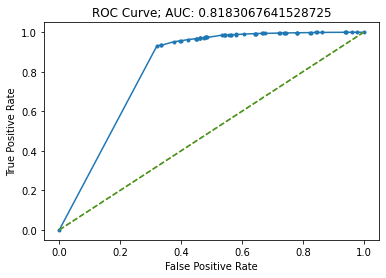

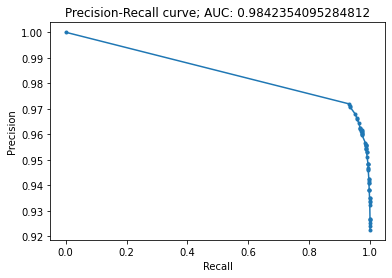

In [11]:
classify(xtrain2, xtest2,ytrain2, ytest2, "soft")


For both the ROC and the Precision-Recall curve, the Area Under Curve (AUC) is approximately the same as with the original dataset attempt. Thus, our new weighted approach doesn't have a huge influence on this attribute for soft voting. 

## Bagging classifier reaches an accuracy of 94.5%
Using the Bagging classifier on a number of different models, we reach an accuracy of 94.5%, which is quite comparable to the scores we achieve with the voting classifier. 

Since the bagging classifier takes a very long time to run, it is commented out in the following code cell. If you want to check the accuracy of 94.5% simply uncomment it and run the cell, but be prepared for a very long processing time. 


In [12]:
'''
models = (LogisticRegression(), RandomForestClassifier(), 
        DecisionTreeClassifier(splitter="random", max_leaf_nodes=16), 
        GaussianNB(), KNeighborsClassifier(), MLPClassifier(), SVC())

def bagging(models):
    for model in models:
        
        bag_clf = BaggingClassifier(
        model,
        n_estimators=500,
        max_samples=1.0,
        bootstrap=True,
        )
    bag_clf.fit(xtrain, ytrain)
    y_pred = bag_clf.predict(xtest)

    bag_clf.fit(xtrain, ytrain)
    y_pred = bag_clf.predict(xtest)
    print(bag_clf.__class__.__name__, accuracy_score(ytest, y_pred))
    
bagging(models)
'''

'\nmodels = (LogisticRegression(), RandomForestClassifier(), \n        DecisionTreeClassifier(splitter="random", max_leaf_nodes=16), \n        GaussianNB(), KNeighborsClassifier(), MLPClassifier(), SVC())\n\ndef bagging(models):\n    for model in models:\n        \n        bag_clf = BaggingClassifier(\n        model,\n        n_estimators=500,\n        max_samples=1.0,\n        bootstrap=True,\n        )\n    bag_clf.fit(xtrain, ytrain)\n    y_pred = bag_clf.predict(xtest)\n\n    bag_clf.fit(xtrain, ytrain)\n    y_pred = bag_clf.predict(xtest)\n    print(bag_clf.__class__.__name__, accuracy_score(ytest, y_pred))\n    \nbagging(models)\n'

# Neural Network 
While we consistently reach accuracy scores of around 94%+ which sounds pretty good, it actually isn't all that great when taking into account that the dumb classifier already achieved an accuracy of 92.5%. Therefore, we want to try a more sophisticated method in order to improve accuracy score even further. We start building a Keras Neural network in order to predict whether a comment will be healthy or not:

### Disclaimer: I wouldn't recommend running all of these cells. It will take a very long time

In [23]:
from keras.models import Sequential
from keras.layers import Dense

# define the keras model
model = Sequential()
model.add(Dense(12, input_dim=7, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
# compile the keras model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
# fit the keras model on the dataset
model.fit(xtrain, ytrain, epochs=150, batch_size=10)
# evaluate the keras model
_, accuracy = model.evaluate(xtest, ytest)
print('Accuracy: %.2f' % (accuracy*100))

Epoch 1/150
26627/26627 [==============================] - 2s 69us/step - loss: 0.2144 - accuracy: 0.9404
Epoch 2/150
26627/26627 [==============================] - 2s 63us/step - loss: 0.1760 - accuracy: 0.9450
Epoch 3/150
26627/26627 [==============================] - 2s 65us/step - loss: 0.1756 - accuracy: 0.9456
Epoch 4/150
26627/26627 [==============================] - 2s 63us/step - loss: 0.1753 - accuracy: 0.9456
Epoch 5/150
26627/26627 [==============================] - 2s 63us/step - loss: 0.1752 - accuracy: 0.9459
Epoch 6/150
26627/26627 [==============================] - 2s 64us/step - loss: 0.1753 - accuracy: 0.9450
Epoch 7/150
26627/26627 [==============================] - 2s 63us/step - loss: 0.1754 - accuracy: 0.9456
Epoch 8/150
26627/26627 [==============================] - 2s 62us/step - loss: 0.1753 - accuracy: 0.9457
Epoch 9/150
26627/26627 [==============================] - 2s 63us/step - loss: 0.1751 - accuracy: 0.9457
Epoch 10/150
26627/26627 [====================

26627/26627 [==============================] - 2s 60us/step - loss: 0.1747 - accuracy: 0.9464
Epoch 78/150
26627/26627 [==============================] - 2s 61us/step - loss: 0.1747 - accuracy: 0.9463
Epoch 79/150
26627/26627 [==============================] - 2s 63us/step - loss: 0.1747 - accuracy: 0.9462
Epoch 80/150
26627/26627 [==============================] - 2s 63us/step - loss: 0.1747 - accuracy: 0.9462
Epoch 81/150
26627/26627 [==============================] - 2s 65us/step - loss: 0.1745 - accuracy: 0.9458
Epoch 82/150
26627/26627 [==============================] - 2s 66us/step - loss: 0.1746 - accuracy: 0.9466
Epoch 83/150
26627/26627 [==============================] - 2s 66us/step - loss: 0.1747 - accuracy: 0.9463
Epoch 84/150
26627/26627 [==============================] - 2s 65us/step - loss: 0.1746 - accuracy: 0.9461
Epoch 85/150
26627/26627 [==============================] - 2s 64us/step - loss: 0.1747 - accuracy: 0.9462
Epoch 86/150
26627/26627 [========================

The initial Keras model reaches an accuracy of 94.61%, which is on the high-end of Ensemble-learning accuracy scores. This proves that there is definitely potential in a neural network approach to this problem.
This 94.61% accuracy was achieved using the original, untransformed dataset. In order to test whether our Weighted dataset works better/worse on the neural network, we train the exact same model on our own weighted dataset as well and compare accuracy scores.

In [14]:
# define the keras model
model = Sequential()
model.add(Dense(12, input_dim=7, activation='sigmoid'))
model.add(Dense(8, activation='sigmoid'))
model.add(Dense(1, activation='sigmoid'))
# compile the keras model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
# fit the keras model on the dataset
model.fit(xtrain2, ytrain2, epochs=150, batch_size=10)
# evaluate the keras model
_, accuracy = model.evaluate(xtest2, ytest2)
print('Accuracy: %.2f' % (accuracy*100))

Epoch 1/150
26627/26627 [==============================] - 2s 57us/step - loss: 0.2900 - accuracy: 0.8898
Epoch 2/150
26627/26627 [==============================] - 1s 53us/step - loss: 0.1740 - accuracy: 0.9353
Epoch 3/150
26627/26627 [==============================] - 1s 53us/step - loss: 0.1657 - accuracy: 0.9418
Epoch 4/150
26627/26627 [==============================] - 1s 53us/step - loss: 0.1641 - accuracy: 0.9422
Epoch 5/150
26627/26627 [==============================] - 1s 53us/step - loss: 0.1628 - accuracy: 0.9431
Epoch 6/150
26627/26627 [==============================] - 1s 52us/step - loss: 0.1616 - accuracy: 0.9438
Epoch 7/150
26627/26627 [==============================] - 1s 54us/step - loss: 0.1607 - accuracy: 0.9437
Epoch 8/150
26627/26627 [==============================] - 1s 53us/step - loss: 0.1602 - accuracy: 0.9439
Epoch 9/150
26627/26627 [==============================] - 1s 53us/step - loss: 0.1596 - accuracy: 0.9443
Epoch 10/150
26627/26627 [====================

26627/26627 [==============================] - 1s 53us/step - loss: 0.1554 - accuracy: 0.9457
Epoch 78/150
26627/26627 [==============================] - 1s 53us/step - loss: 0.1554 - accuracy: 0.9455
Epoch 79/150
26627/26627 [==============================] - 1s 53us/step - loss: 0.1554 - accuracy: 0.9457
Epoch 80/150
26627/26627 [==============================] - 1s 54us/step - loss: 0.1553 - accuracy: 0.9459
Epoch 81/150
26627/26627 [==============================] - 1s 53us/step - loss: 0.1554 - accuracy: 0.9460
Epoch 82/150
26627/26627 [==============================] - 1s 53us/step - loss: 0.1553 - accuracy: 0.9459
Epoch 83/150
26627/26627 [==============================] - 1s 53us/step - loss: 0.1554 - accuracy: 0.9455
Epoch 84/150
26627/26627 [==============================] - 1s 53us/step - loss: 0.1554 - accuracy: 0.9457
Epoch 85/150
26627/26627 [==============================] - 1s 54us/step - loss: 0.1553 - accuracy: 0.9456
Epoch 86/150
26627/26627 [========================

Using the weighted dataset, we get an accuracy of 94.66%, which is pretty much the same as the original dataset. It is likely that it doesn't matter too much which one is used, but since the weighted dataset has a slightely higher accuracy we will continue using that one. (xtrain2 rather than xtrain)


To test whether we can improve our accuracy even further, we try a number of different setups for this model. We start with heavily increasing the batch size:

In [15]:
# define the keras model
model = Sequential()
model.add(Dense(12, input_dim=7, activation='sigmoid'))
model.add(Dense(8, activation='sigmoid'))
model.add(Dense(1, activation='sigmoid'))
# compile the keras model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
# fit the keras model on the dataset
model.fit(xtrain2, ytrain2, epochs=150, batch_size=1000)
# evaluate the keras model
_, accuracy = model.evaluate(xtest2, ytest2)
print('Accuracy: %.2f' % (accuracy*100))

Epoch 1/150
26627/26627 [==============================] - 0s 5us/step - loss: 0.3885 - accuracy: 0.9251
Epoch 2/150
26627/26627 [==============================] - 0s 1us/step - loss: 0.3445 - accuracy: 0.9251
Epoch 3/150
26627/26627 [==============================] - 0s 1us/step - loss: 0.3148 - accuracy: 0.9251
Epoch 4/150
26627/26627 [==============================] - 0s 1us/step - loss: 0.2950 - accuracy: 0.9251
Epoch 5/150
26627/26627 [==============================] - 0s 1us/step - loss: 0.2818 - accuracy: 0.9251
Epoch 6/150
26627/26627 [==============================] - 0s 1us/step - loss: 0.2726 - accuracy: 0.9251
Epoch 7/150
26627/26627 [==============================] - 0s 1us/step - loss: 0.2662 - accuracy: 0.9251
Epoch 8/150
26627/26627 [==============================] - 0s 1us/step - loss: 0.2614 - accuracy: 0.9251
Epoch 9/150
26627/26627 [==============================] - 0s 1us/step - loss: 0.2577 - accuracy: 0.9251
Epoch 10/150
26627/26627 [=============================

26627/26627 [==============================] - 0s 1us/step - loss: 0.1646 - accuracy: 0.9426
Epoch 79/150
26627/26627 [==============================] - 0s 1us/step - loss: 0.1644 - accuracy: 0.9427
Epoch 80/150
26627/26627 [==============================] - 0s 1us/step - loss: 0.1643 - accuracy: 0.9430
Epoch 81/150
26627/26627 [==============================] - 0s 1us/step - loss: 0.1642 - accuracy: 0.9429
Epoch 82/150
26627/26627 [==============================] - 0s 1us/step - loss: 0.1640 - accuracy: 0.9430
Epoch 83/150
26627/26627 [==============================] - 0s 1us/step - loss: 0.1639 - accuracy: 0.9431
Epoch 84/150
26627/26627 [==============================] - 0s 1us/step - loss: 0.1638 - accuracy: 0.9433
Epoch 85/150
26627/26627 [==============================] - 0s 1us/step - loss: 0.1636 - accuracy: 0.9431
Epoch 86/150
26627/26627 [==============================] - 0s 1us/step - loss: 0.1635 - accuracy: 0.9430
Epoch 87/150
26627/26627 [==============================] -

The model with increased batch size leads to the exact same accuracy of 94.61%, but the model runs exponentially faster. This faster run speed opens up many more time-efficiency possibilities, including a drastic increase of the number of epochs. Allowing the model to train more often should logically increase its accuracy, so we now try increasing both the batch size and the number of epochs:

In [16]:
# define the keras model
model = Sequential()
model.add(Dense(12, input_dim=7, activation='sigmoid'))
model.add(Dense(8, activation='sigmoid'))
model.add(Dense(1, activation='sigmoid'))
# compile the keras model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
# fit the keras model on the dataset
model.fit(xtrain2, ytrain2, epochs=2000, batch_size=1000)
# evaluate the keras model
_, accuracy = model.evaluate(xtest2, ytest2)
print('Accuracy: %.2f' % (accuracy*100))

Epoch 1/2000
26627/26627 [==============================] - 0s 5us/step - loss: 0.6610 - accuracy: 0.7038
Epoch 2/2000
26627/26627 [==============================] - 0s 1us/step - loss: 0.5450 - accuracy: 0.9251
Epoch 3/2000
26627/26627 [==============================] - 0s 1us/step - loss: 0.4622 - accuracy: 0.9251
Epoch 4/2000
26627/26627 [==============================] - 0s 1us/step - loss: 0.4046 - accuracy: 0.9251
Epoch 5/2000
26627/26627 [==============================] - 0s 1us/step - loss: 0.3643 - accuracy: 0.9251
Epoch 6/2000
26627/26627 [==============================] - 0s 1us/step - loss: 0.3358 - accuracy: 0.9251
Epoch 7/2000
26627/26627 [==============================] - 0s 1us/step - loss: 0.3152 - accuracy: 0.9251
Epoch 8/2000
26627/26627 [==============================] - 0s 1us/step - loss: 0.2999 - accuracy: 0.9251
Epoch 9/2000
26627/26627 [==============================] - 0s 1us/step - loss: 0.2883 - accuracy: 0.9251
Epoch 10/2000
26627/26627 [===================

26627/26627 [==============================] - 0s 1us/step - loss: 0.1694 - accuracy: 0.9419
Epoch 78/2000
26627/26627 [==============================] - 0s 1us/step - loss: 0.1692 - accuracy: 0.9420
Epoch 79/2000
26627/26627 [==============================] - 0s 1us/step - loss: 0.1690 - accuracy: 0.9422
Epoch 80/2000
26627/26627 [==============================] - 0s 1us/step - loss: 0.1688 - accuracy: 0.9421
Epoch 81/2000
26627/26627 [==============================] - 0s 1us/step - loss: 0.1686 - accuracy: 0.9419
Epoch 82/2000
26627/26627 [==============================] - 0s 1us/step - loss: 0.1684 - accuracy: 0.9419
Epoch 83/2000
26627/26627 [==============================] - 0s 1us/step - loss: 0.1683 - accuracy: 0.9419
Epoch 84/2000
26627/26627 [==============================] - 0s 1us/step - loss: 0.1681 - accuracy: 0.9420
Epoch 85/2000
26627/26627 [==============================] - 0s 1us/step - loss: 0.1679 - accuracy: 0.9419
Epoch 86/2000
26627/26627 [========================

26627/26627 [==============================] - 0s 1us/step - loss: 0.1601 - accuracy: 0.9442
Epoch 154/2000
26627/26627 [==============================] - 0s 1us/step - loss: 0.1600 - accuracy: 0.9442
Epoch 155/2000
26627/26627 [==============================] - 0s 1us/step - loss: 0.1600 - accuracy: 0.9442
Epoch 156/2000
26627/26627 [==============================] - 0s 1us/step - loss: 0.1599 - accuracy: 0.9442
Epoch 157/2000
26627/26627 [==============================] - 0s 1us/step - loss: 0.1598 - accuracy: 0.9442
Epoch 158/2000
26627/26627 [==============================] - 0s 1us/step - loss: 0.1598 - accuracy: 0.9442
Epoch 159/2000
26627/26627 [==============================] - 0s 1us/step - loss: 0.1597 - accuracy: 0.9441
Epoch 160/2000
26627/26627 [==============================] - 0s 1us/step - loss: 0.1597 - accuracy: 0.9442
Epoch 161/2000
26627/26627 [==============================] - 0s 1us/step - loss: 0.1596 - accuracy: 0.9442
Epoch 162/2000
26627/26627 [===============

Epoch 229/2000
26627/26627 [==============================] - 0s 1us/step - loss: 0.1575 - accuracy: 0.9451
Epoch 230/2000
26627/26627 [==============================] - 0s 1us/step - loss: 0.1575 - accuracy: 0.9449
Epoch 231/2000
26627/26627 [==============================] - 0s 1us/step - loss: 0.1575 - accuracy: 0.9452
Epoch 232/2000
26627/26627 [==============================] - 0s 1us/step - loss: 0.1575 - accuracy: 0.9453
Epoch 233/2000
26627/26627 [==============================] - 0s 1us/step - loss: 0.1575 - accuracy: 0.9451
Epoch 234/2000
26627/26627 [==============================] - 0s 1us/step - loss: 0.1574 - accuracy: 0.9450
Epoch 235/2000
26627/26627 [==============================] - 0s 1us/step - loss: 0.1574 - accuracy: 0.9451
Epoch 236/2000
26627/26627 [==============================] - 0s 1us/step - loss: 0.1574 - accuracy: 0.9451
Epoch 237/2000
26627/26627 [==============================] - 0s 1us/step - loss: 0.1574 - accuracy: 0.9452
Epoch 238/2000
26627/26627 [

26627/26627 [==============================] - 0s 1us/step - loss: 0.1567 - accuracy: 0.9452
Epoch 305/2000
26627/26627 [==============================] - 0s 1us/step - loss: 0.1567 - accuracy: 0.9452
Epoch 306/2000
26627/26627 [==============================] - 0s 1us/step - loss: 0.1567 - accuracy: 0.9451
Epoch 307/2000
26627/26627 [==============================] - 0s 1us/step - loss: 0.1567 - accuracy: 0.9454
Epoch 308/2000
26627/26627 [==============================] - 0s 1us/step - loss: 0.1566 - accuracy: 0.9450
Epoch 309/2000
26627/26627 [==============================] - 0s 1us/step - loss: 0.1567 - accuracy: 0.9450
Epoch 310/2000
26627/26627 [==============================] - 0s 1us/step - loss: 0.1566 - accuracy: 0.9451
Epoch 311/2000
26627/26627 [==============================] - 0s 1us/step - loss: 0.1567 - accuracy: 0.9450
Epoch 312/2000
26627/26627 [==============================] - 0s 1us/step - loss: 0.1566 - accuracy: 0.9451
Epoch 313/2000
26627/26627 [===============

Epoch 380/2000
26627/26627 [==============================] - 0s 1us/step - loss: 0.1563 - accuracy: 0.9455
Epoch 381/2000
26627/26627 [==============================] - 0s 1us/step - loss: 0.1563 - accuracy: 0.9452
Epoch 382/2000
26627/26627 [==============================] - 0s 1us/step - loss: 0.1563 - accuracy: 0.9451
Epoch 383/2000
26627/26627 [==============================] - 0s 1us/step - loss: 0.1564 - accuracy: 0.9451
Epoch 384/2000
26627/26627 [==============================] - 0s 1us/step - loss: 0.1563 - accuracy: 0.9451
Epoch 385/2000
26627/26627 [==============================] - 0s 1us/step - loss: 0.1563 - accuracy: 0.9451
Epoch 386/2000
26627/26627 [==============================] - 0s 1us/step - loss: 0.1563 - accuracy: 0.9448
Epoch 387/2000
26627/26627 [==============================] - 0s 1us/step - loss: 0.1563 - accuracy: 0.9454
Epoch 388/2000
26627/26627 [==============================] - 0s 1us/step - loss: 0.1563 - accuracy: 0.9451
Epoch 389/2000
26627/26627 [

26627/26627 [==============================] - 0s 1us/step - loss: 0.1561 - accuracy: 0.9450
Epoch 456/2000
26627/26627 [==============================] - 0s 1us/step - loss: 0.1561 - accuracy: 0.9448
Epoch 457/2000
26627/26627 [==============================] - 0s 1us/step - loss: 0.1561 - accuracy: 0.9451
Epoch 458/2000
26627/26627 [==============================] - 0s 1us/step - loss: 0.1561 - accuracy: 0.9450
Epoch 459/2000
26627/26627 [==============================] - 0s 1us/step - loss: 0.1561 - accuracy: 0.9451
Epoch 460/2000
26627/26627 [==============================] - 0s 1us/step - loss: 0.1561 - accuracy: 0.9454
Epoch 461/2000
26627/26627 [==============================] - 0s 1us/step - loss: 0.1561 - accuracy: 0.9451
Epoch 462/2000
26627/26627 [==============================] - 0s 1us/step - loss: 0.1561 - accuracy: 0.9450
Epoch 463/2000
26627/26627 [==============================] - 0s 1us/step - loss: 0.1561 - accuracy: 0.9450
Epoch 464/2000
26627/26627 [===============

Epoch 531/2000
26627/26627 [==============================] - 0s 1us/step - loss: 0.1559 - accuracy: 0.9452
Epoch 532/2000
26627/26627 [==============================] - 0s 1us/step - loss: 0.1559 - accuracy: 0.9453
Epoch 533/2000
26627/26627 [==============================] - 0s 1us/step - loss: 0.1559 - accuracy: 0.9453
Epoch 534/2000
26627/26627 [==============================] - 0s 1us/step - loss: 0.1559 - accuracy: 0.9454
Epoch 535/2000
26627/26627 [==============================] - 0s 1us/step - loss: 0.1559 - accuracy: 0.9450
Epoch 536/2000
26627/26627 [==============================] - 0s 1us/step - loss: 0.1559 - accuracy: 0.9449
Epoch 537/2000
26627/26627 [==============================] - 0s 1us/step - loss: 0.1559 - accuracy: 0.9451
Epoch 538/2000
26627/26627 [==============================] - 0s 1us/step - loss: 0.1559 - accuracy: 0.9450
Epoch 539/2000
26627/26627 [==============================] - 0s 1us/step - loss: 0.1559 - accuracy: 0.9451
Epoch 540/2000
26627/26627 [

26627/26627 [==============================] - 0s 1us/step - loss: 0.1557 - accuracy: 0.9451
Epoch 607/2000
26627/26627 [==============================] - 0s 1us/step - loss: 0.1557 - accuracy: 0.9451
Epoch 608/2000
26627/26627 [==============================] - 0s 1us/step - loss: 0.1558 - accuracy: 0.9453
Epoch 609/2000
26627/26627 [==============================] - 0s 1us/step - loss: 0.1558 - accuracy: 0.9455
Epoch 610/2000
26627/26627 [==============================] - 0s 1us/step - loss: 0.1557 - accuracy: 0.9451
Epoch 611/2000
26627/26627 [==============================] - 0s 1us/step - loss: 0.1557 - accuracy: 0.9452
Epoch 612/2000
26627/26627 [==============================] - 0s 1us/step - loss: 0.1557 - accuracy: 0.9454
Epoch 613/2000
26627/26627 [==============================] - 0s 1us/step - loss: 0.1557 - accuracy: 0.9453
Epoch 614/2000
26627/26627 [==============================] - 0s 1us/step - loss: 0.1556 - accuracy: 0.9451
Epoch 615/2000
26627/26627 [===============

Epoch 682/2000
26627/26627 [==============================] - 0s 1us/step - loss: 0.1555 - accuracy: 0.9455
Epoch 683/2000
26627/26627 [==============================] - 0s 1us/step - loss: 0.1554 - accuracy: 0.9452
Epoch 684/2000
26627/26627 [==============================] - 0s 1us/step - loss: 0.1555 - accuracy: 0.9452
Epoch 685/2000
26627/26627 [==============================] - 0s 1us/step - loss: 0.1555 - accuracy: 0.9453
Epoch 686/2000
26627/26627 [==============================] - 0s 1us/step - loss: 0.1555 - accuracy: 0.9454
Epoch 687/2000
26627/26627 [==============================] - 0s 1us/step - loss: 0.1555 - accuracy: 0.9454
Epoch 688/2000
26627/26627 [==============================] - 0s 1us/step - loss: 0.1555 - accuracy: 0.9454
Epoch 689/2000
26627/26627 [==============================] - 0s 1us/step - loss: 0.1555 - accuracy: 0.9456
Epoch 690/2000
26627/26627 [==============================] - 0s 1us/step - loss: 0.1555 - accuracy: 0.9454
Epoch 691/2000
26627/26627 [

26627/26627 [==============================] - 0s 1us/step - loss: 0.1553 - accuracy: 0.9455
Epoch 758/2000
26627/26627 [==============================] - 0s 1us/step - loss: 0.1553 - accuracy: 0.9454
Epoch 759/2000
26627/26627 [==============================] - 0s 1us/step - loss: 0.1553 - accuracy: 0.9456
Epoch 760/2000
26627/26627 [==============================] - 0s 1us/step - loss: 0.1553 - accuracy: 0.9455
Epoch 761/2000
26627/26627 [==============================] - 0s 1us/step - loss: 0.1553 - accuracy: 0.9455
Epoch 762/2000
26627/26627 [==============================] - 0s 1us/step - loss: 0.1553 - accuracy: 0.9453
Epoch 763/2000
26627/26627 [==============================] - 0s 1us/step - loss: 0.1553 - accuracy: 0.9457
Epoch 764/2000
26627/26627 [==============================] - 0s 1us/step - loss: 0.1552 - accuracy: 0.9455
Epoch 765/2000
26627/26627 [==============================] - 0s 1us/step - loss: 0.1552 - accuracy: 0.9455
Epoch 766/2000
26627/26627 [===============

Epoch 833/2000
26627/26627 [==============================] - 0s 1us/step - loss: 0.1550 - accuracy: 0.9456
Epoch 834/2000
26627/26627 [==============================] - 0s 1us/step - loss: 0.1550 - accuracy: 0.9457
Epoch 835/2000
26627/26627 [==============================] - 0s 1us/step - loss: 0.1550 - accuracy: 0.9457
Epoch 836/2000
26627/26627 [==============================] - 0s 1us/step - loss: 0.1550 - accuracy: 0.9457
Epoch 837/2000
26627/26627 [==============================] - 0s 1us/step - loss: 0.1550 - accuracy: 0.9458
Epoch 838/2000
26627/26627 [==============================] - 0s 1us/step - loss: 0.1551 - accuracy: 0.9457
Epoch 839/2000
26627/26627 [==============================] - 0s 1us/step - loss: 0.1551 - accuracy: 0.9457
Epoch 840/2000
26627/26627 [==============================] - 0s 1us/step - loss: 0.1550 - accuracy: 0.9458
Epoch 841/2000
26627/26627 [==============================] - 0s 1us/step - loss: 0.1550 - accuracy: 0.9457
Epoch 842/2000
26627/26627 [

26627/26627 [==============================] - 0s 1us/step - loss: 0.1548 - accuracy: 0.9460
Epoch 909/2000
26627/26627 [==============================] - 0s 1us/step - loss: 0.1548 - accuracy: 0.9458
Epoch 910/2000
26627/26627 [==============================] - 0s 1us/step - loss: 0.1548 - accuracy: 0.9460
Epoch 911/2000
26627/26627 [==============================] - 0s 1us/step - loss: 0.1548 - accuracy: 0.9458
Epoch 912/2000
26627/26627 [==============================] - 0s 1us/step - loss: 0.1548 - accuracy: 0.9460
Epoch 913/2000
26627/26627 [==============================] - 0s 1us/step - loss: 0.1548 - accuracy: 0.9461
Epoch 914/2000
26627/26627 [==============================] - 0s 1us/step - loss: 0.1549 - accuracy: 0.9458
Epoch 915/2000
26627/26627 [==============================] - 0s 1us/step - loss: 0.1549 - accuracy: 0.9461
Epoch 916/2000
26627/26627 [==============================] - 0s 1us/step - loss: 0.1548 - accuracy: 0.9457
Epoch 917/2000
26627/26627 [===============

Epoch 984/2000
26627/26627 [==============================] - 0s 1us/step - loss: 0.1546 - accuracy: 0.9461
Epoch 985/2000
26627/26627 [==============================] - 0s 1us/step - loss: 0.1546 - accuracy: 0.9462
Epoch 986/2000
26627/26627 [==============================] - 0s 1us/step - loss: 0.1546 - accuracy: 0.9462
Epoch 987/2000
26627/26627 [==============================] - 0s 1us/step - loss: 0.1546 - accuracy: 0.9461
Epoch 988/2000
26627/26627 [==============================] - 0s 1us/step - loss: 0.1546 - accuracy: 0.9458
Epoch 989/2000
26627/26627 [==============================] - 0s 1us/step - loss: 0.1546 - accuracy: 0.9461
Epoch 990/2000
26627/26627 [==============================] - 0s 1us/step - loss: 0.1546 - accuracy: 0.9462
Epoch 991/2000
26627/26627 [==============================] - 0s 1us/step - loss: 0.1546 - accuracy: 0.9460
Epoch 992/2000
26627/26627 [==============================] - 0s 1us/step - loss: 0.1545 - accuracy: 0.9463
Epoch 993/2000
26627/26627 [

26627/26627 [==============================] - 0s 1us/step - loss: 0.1544 - accuracy: 0.9464
Epoch 1060/2000
26627/26627 [==============================] - 0s 1us/step - loss: 0.1543 - accuracy: 0.9464
Epoch 1061/2000
26627/26627 [==============================] - 0s 1us/step - loss: 0.1543 - accuracy: 0.9462
Epoch 1062/2000
26627/26627 [==============================] - 0s 1us/step - loss: 0.1543 - accuracy: 0.9466
Epoch 1063/2000
26627/26627 [==============================] - 0s 1us/step - loss: 0.1543 - accuracy: 0.9462
Epoch 1064/2000
26627/26627 [==============================] - 0s 1us/step - loss: 0.1543 - accuracy: 0.9462
Epoch 1065/2000
26627/26627 [==============================] - 0s 1us/step - loss: 0.1543 - accuracy: 0.9465
Epoch 1066/2000
26627/26627 [==============================] - 0s 1us/step - loss: 0.1543 - accuracy: 0.9466
Epoch 1067/2000
26627/26627 [==============================] - 0s 1us/step - loss: 0.1543 - accuracy: 0.9463
Epoch 1068/2000
26627/26627 [======

26627/26627 [==============================] - 0s 1us/step - loss: 0.1541 - accuracy: 0.9465
Epoch 1135/2000
26627/26627 [==============================] - 0s 1us/step - loss: 0.1541 - accuracy: 0.9464
Epoch 1136/2000
26627/26627 [==============================] - 0s 1us/step - loss: 0.1541 - accuracy: 0.9466
Epoch 1137/2000
26627/26627 [==============================] - 0s 1us/step - loss: 0.1540 - accuracy: 0.9464
Epoch 1138/2000
26627/26627 [==============================] - 0s 1us/step - loss: 0.1541 - accuracy: 0.9464
Epoch 1139/2000
26627/26627 [==============================] - 0s 1us/step - loss: 0.1541 - accuracy: 0.9465
Epoch 1140/2000
26627/26627 [==============================] - 0s 1us/step - loss: 0.1540 - accuracy: 0.9467
Epoch 1141/2000
26627/26627 [==============================] - 0s 1us/step - loss: 0.1541 - accuracy: 0.9464
Epoch 1142/2000
26627/26627 [==============================] - 0s 1us/step - loss: 0.1540 - accuracy: 0.9466
Epoch 1143/2000
26627/26627 [======

26627/26627 [==============================] - 0s 1us/step - loss: 0.1538 - accuracy: 0.9467
Epoch 1210/2000
26627/26627 [==============================] - 0s 1us/step - loss: 0.1539 - accuracy: 0.9464
Epoch 1211/2000
26627/26627 [==============================] - 0s 1us/step - loss: 0.1538 - accuracy: 0.9467
Epoch 1212/2000
26627/26627 [==============================] - 0s 1us/step - loss: 0.1539 - accuracy: 0.9468
Epoch 1213/2000
26627/26627 [==============================] - 0s 1us/step - loss: 0.1539 - accuracy: 0.9460
Epoch 1214/2000
26627/26627 [==============================] - 0s 1us/step - loss: 0.1538 - accuracy: 0.9467
Epoch 1215/2000
26627/26627 [==============================] - 0s 1us/step - loss: 0.1538 - accuracy: 0.9467
Epoch 1216/2000
26627/26627 [==============================] - 0s 1us/step - loss: 0.1539 - accuracy: 0.9466
Epoch 1217/2000
26627/26627 [==============================] - 0s 1us/step - loss: 0.1538 - accuracy: 0.9467
Epoch 1218/2000
26627/26627 [======

26627/26627 [==============================] - 0s 1us/step - loss: 0.1536 - accuracy: 0.9468
Epoch 1285/2000
26627/26627 [==============================] - 0s 1us/step - loss: 0.1536 - accuracy: 0.9463
Epoch 1286/2000
26627/26627 [==============================] - 0s 1us/step - loss: 0.1536 - accuracy: 0.9467
Epoch 1287/2000
26627/26627 [==============================] - 0s 1us/step - loss: 0.1536 - accuracy: 0.9467
Epoch 1288/2000
26627/26627 [==============================] - 0s 1us/step - loss: 0.1536 - accuracy: 0.9467
Epoch 1289/2000
26627/26627 [==============================] - 0s 1us/step - loss: 0.1536 - accuracy: 0.9465
Epoch 1290/2000
26627/26627 [==============================] - 0s 1us/step - loss: 0.1536 - accuracy: 0.9465
Epoch 1291/2000
26627/26627 [==============================] - 0s 1us/step - loss: 0.1537 - accuracy: 0.9467
Epoch 1292/2000
26627/26627 [==============================] - 0s 1us/step - loss: 0.1536 - accuracy: 0.9464
Epoch 1293/2000
26627/26627 [======

26627/26627 [==============================] - 0s 1us/step - loss: 0.1534 - accuracy: 0.9466
Epoch 1360/2000
26627/26627 [==============================] - 0s 1us/step - loss: 0.1534 - accuracy: 0.9467
Epoch 1361/2000
26627/26627 [==============================] - 0s 1us/step - loss: 0.1534 - accuracy: 0.9465
Epoch 1362/2000
26627/26627 [==============================] - 0s 1us/step - loss: 0.1534 - accuracy: 0.9466
Epoch 1363/2000
26627/26627 [==============================] - 0s 1us/step - loss: 0.1534 - accuracy: 0.9463
Epoch 1364/2000
26627/26627 [==============================] - 0s 1us/step - loss: 0.1534 - accuracy: 0.9465
Epoch 1365/2000
26627/26627 [==============================] - 0s 1us/step - loss: 0.1534 - accuracy: 0.9465
Epoch 1366/2000
26627/26627 [==============================] - 0s 1us/step - loss: 0.1534 - accuracy: 0.9467
Epoch 1367/2000
26627/26627 [==============================] - 0s 1us/step - loss: 0.1534 - accuracy: 0.9467
Epoch 1368/2000
26627/26627 [======

26627/26627 [==============================] - 0s 1us/step - loss: 0.1533 - accuracy: 0.9466
Epoch 1434/2000
26627/26627 [==============================] - 0s 1us/step - loss: 0.1532 - accuracy: 0.9466
Epoch 1435/2000
26627/26627 [==============================] - 0s 1us/step - loss: 0.1532 - accuracy: 0.9466
Epoch 1436/2000
26627/26627 [==============================] - 0s 1us/step - loss: 0.1532 - accuracy: 0.9465
Epoch 1437/2000
26627/26627 [==============================] - 0s 1us/step - loss: 0.1532 - accuracy: 0.9465
Epoch 1438/2000
26627/26627 [==============================] - 0s 1us/step - loss: 0.1532 - accuracy: 0.9464
Epoch 1439/2000
26627/26627 [==============================] - 0s 1us/step - loss: 0.1532 - accuracy: 0.9465
Epoch 1440/2000
26627/26627 [==============================] - 0s 1us/step - loss: 0.1534 - accuracy: 0.9463
Epoch 1441/2000
26627/26627 [==============================] - 0s 1us/step - loss: 0.1533 - accuracy: 0.9463
Epoch 1442/2000
26627/26627 [======

26627/26627 [==============================] - 0s 1us/step - loss: 0.1531 - accuracy: 0.9468
Epoch 1509/2000
26627/26627 [==============================] - 0s 1us/step - loss: 0.1531 - accuracy: 0.9464
Epoch 1510/2000
26627/26627 [==============================] - 0s 1us/step - loss: 0.1531 - accuracy: 0.9464
Epoch 1511/2000
26627/26627 [==============================] - 0s 1us/step - loss: 0.1531 - accuracy: 0.9464
Epoch 1512/2000
26627/26627 [==============================] - 0s 1us/step - loss: 0.1531 - accuracy: 0.9465
Epoch 1513/2000
26627/26627 [==============================] - 0s 1us/step - loss: 0.1532 - accuracy: 0.9466
Epoch 1514/2000
26627/26627 [==============================] - 0s 1us/step - loss: 0.1531 - accuracy: 0.9463
Epoch 1515/2000
26627/26627 [==============================] - 0s 1us/step - loss: 0.1531 - accuracy: 0.9466
Epoch 1516/2000
26627/26627 [==============================] - 0s 1us/step - loss: 0.1531 - accuracy: 0.9466
Epoch 1517/2000
26627/26627 [======

26627/26627 [==============================] - 0s 1us/step - loss: 0.1530 - accuracy: 0.9465
Epoch 1584/2000
26627/26627 [==============================] - 0s 1us/step - loss: 0.1531 - accuracy: 0.9460
Epoch 1585/2000
26627/26627 [==============================] - 0s 1us/step - loss: 0.1531 - accuracy: 0.9466
Epoch 1586/2000
26627/26627 [==============================] - 0s 1us/step - loss: 0.1530 - accuracy: 0.9461
Epoch 1587/2000
26627/26627 [==============================] - 0s 1us/step - loss: 0.1530 - accuracy: 0.9464
Epoch 1588/2000
26627/26627 [==============================] - 0s 1us/step - loss: 0.1530 - accuracy: 0.9463
Epoch 1589/2000
26627/26627 [==============================] - 0s 1us/step - loss: 0.1530 - accuracy: 0.9465
Epoch 1590/2000
26627/26627 [==============================] - 0s 1us/step - loss: 0.1530 - accuracy: 0.9464
Epoch 1591/2000
26627/26627 [==============================] - 0s 1us/step - loss: 0.1530 - accuracy: 0.9464
Epoch 1592/2000
26627/26627 [======

26627/26627 [==============================] - 0s 1us/step - loss: 0.1529 - accuracy: 0.9462
Epoch 1659/2000
26627/26627 [==============================] - 0s 1us/step - loss: 0.1529 - accuracy: 0.9466
Epoch 1660/2000
26627/26627 [==============================] - 0s 1us/step - loss: 0.1529 - accuracy: 0.9463
Epoch 1661/2000
26627/26627 [==============================] - 0s 1us/step - loss: 0.1530 - accuracy: 0.9465
Epoch 1662/2000
26627/26627 [==============================] - 0s 1us/step - loss: 0.1529 - accuracy: 0.9464
Epoch 1663/2000
26627/26627 [==============================] - 0s 1us/step - loss: 0.1529 - accuracy: 0.9466
Epoch 1664/2000
26627/26627 [==============================] - 0s 1us/step - loss: 0.1529 - accuracy: 0.9464
Epoch 1665/2000
26627/26627 [==============================] - 0s 1us/step - loss: 0.1529 - accuracy: 0.9462
Epoch 1666/2000
26627/26627 [==============================] - 0s 1us/step - loss: 0.1529 - accuracy: 0.9459
Epoch 1667/2000
26627/26627 [======

26627/26627 [==============================] - 0s 1us/step - loss: 0.1528 - accuracy: 0.9462
Epoch 1734/2000
26627/26627 [==============================] - 0s 1us/step - loss: 0.1528 - accuracy: 0.9463
Epoch 1735/2000
26627/26627 [==============================] - 0s 1us/step - loss: 0.1529 - accuracy: 0.9465
Epoch 1736/2000
26627/26627 [==============================] - 0s 1us/step - loss: 0.1528 - accuracy: 0.9465
Epoch 1737/2000
26627/26627 [==============================] - 0s 1us/step - loss: 0.1528 - accuracy: 0.9464
Epoch 1738/2000
26627/26627 [==============================] - 0s 1us/step - loss: 0.1528 - accuracy: 0.9464
Epoch 1739/2000
26627/26627 [==============================] - 0s 1us/step - loss: 0.1528 - accuracy: 0.9464
Epoch 1740/2000
26627/26627 [==============================] - 0s 1us/step - loss: 0.1528 - accuracy: 0.9461
Epoch 1741/2000
26627/26627 [==============================] - 0s 1us/step - loss: 0.1528 - accuracy: 0.9463
Epoch 1742/2000
26627/26627 [======

26627/26627 [==============================] - 0s 1us/step - loss: 0.1528 - accuracy: 0.9464
Epoch 1809/2000
26627/26627 [==============================] - 0s 1us/step - loss: 0.1527 - accuracy: 0.9464
Epoch 1810/2000
26627/26627 [==============================] - 0s 1us/step - loss: 0.1527 - accuracy: 0.9463
Epoch 1811/2000
26627/26627 [==============================] - 0s 1us/step - loss: 0.1528 - accuracy: 0.9463
Epoch 1812/2000
26627/26627 [==============================] - 0s 1us/step - loss: 0.1528 - accuracy: 0.9464
Epoch 1813/2000
26627/26627 [==============================] - 0s 1us/step - loss: 0.1528 - accuracy: 0.9463
Epoch 1814/2000
26627/26627 [==============================] - 0s 1us/step - loss: 0.1528 - accuracy: 0.9464
Epoch 1815/2000
26627/26627 [==============================] - 0s 1us/step - loss: 0.1528 - accuracy: 0.9464
Epoch 1816/2000
26627/26627 [==============================] - 0s 1us/step - loss: 0.1528 - accuracy: 0.9464
Epoch 1817/2000
26627/26627 [======

26627/26627 [==============================] - 0s 1us/step - loss: 0.1527 - accuracy: 0.9464
Epoch 1884/2000
26627/26627 [==============================] - 0s 1us/step - loss: 0.1527 - accuracy: 0.9462
Epoch 1885/2000
26627/26627 [==============================] - 0s 1us/step - loss: 0.1527 - accuracy: 0.9463
Epoch 1886/2000
26627/26627 [==============================] - 0s 1us/step - loss: 0.1527 - accuracy: 0.9464
Epoch 1887/2000
26627/26627 [==============================] - 0s 1us/step - loss: 0.1527 - accuracy: 0.9463
Epoch 1888/2000
26627/26627 [==============================] - 0s 1us/step - loss: 0.1527 - accuracy: 0.9464
Epoch 1889/2000
26627/26627 [==============================] - 0s 1us/step - loss: 0.1527 - accuracy: 0.9465
Epoch 1890/2000
26627/26627 [==============================] - 0s 1us/step - loss: 0.1527 - accuracy: 0.9465
Epoch 1891/2000
26627/26627 [==============================] - 0s 1us/step - loss: 0.1527 - accuracy: 0.9463
Epoch 1892/2000
26627/26627 [======

26627/26627 [==============================] - 0s 1us/step - loss: 0.1527 - accuracy: 0.9462
Epoch 1959/2000
26627/26627 [==============================] - 0s 1us/step - loss: 0.1526 - accuracy: 0.9464
Epoch 1960/2000
26627/26627 [==============================] - 0s 1us/step - loss: 0.1528 - accuracy: 0.9463
Epoch 1961/2000
26627/26627 [==============================] - 0s 1us/step - loss: 0.1527 - accuracy: 0.9463
Epoch 1962/2000
26627/26627 [==============================] - 0s 1us/step - loss: 0.1526 - accuracy: 0.9466
Epoch 1963/2000
26627/26627 [==============================] - 0s 1us/step - loss: 0.1526 - accuracy: 0.9464
Epoch 1964/2000
26627/26627 [==============================] - 0s 1us/step - loss: 0.1526 - accuracy: 0.9466
Epoch 1965/2000
26627/26627 [==============================] - 0s 1us/step - loss: 0.1526 - accuracy: 0.9465
Epoch 1966/2000
26627/26627 [==============================] - 0s 1us/step - loss: 0.1526 - accuracy: 0.9463
Epoch 1967/2000
26627/26627 [======

# New accuracy high-score by the Keras model: 94.76%
Increasing the number of epochs does indeed increase the accuracy towards 94.76%, which is the highest accuracy score we have achieved yet: higher than the ensemble learning techniques.

In order to try and further improve the accuracy of this model with a high number of epochs and a large batch-size, we try adding more layers to the model too:

In [17]:
# define the keras model
model = Sequential()
model.add(Dense(60, input_dim=7, activation='sigmoid'))
for node_numb in [50,45,40,35,30,28,25,22,20,18,15,12,10,8,5]:
    model.add(Dense(node_numb, activation='sigmoid'))
model.add(Dense(1, activation='sigmoid'))
# compile the keras model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
# fit the keras model on the dataset
model.fit(xtrain, ytrain, epochs=2000, batch_size=1000)
# evaluate the keras model
_, accuracy = model.evaluate(xtest,ytest)
print('Accuracy: %.2f' % (accuracy*100))

Epoch 1/2000
26627/26627 [==============================] - 0s 17us/step - loss: 0.8514 - accuracy: 0.0739
Epoch 2/2000
26627/26627 [==============================] - 0s 3us/step - loss: 0.7401 - accuracy: 0.0937
Epoch 3/2000
26627/26627 [==============================] - 0s 3us/step - loss: 0.6488 - accuracy: 0.9261
Epoch 4/2000
26627/26627 [==============================] - 0s 3us/step - loss: 0.5747 - accuracy: 0.9261
Epoch 5/2000
26627/26627 [==============================] - 0s 3us/step - loss: 0.5147 - accuracy: 0.9261
Epoch 6/2000
26627/26627 [==============================] - 0s 3us/step - loss: 0.4664 - accuracy: 0.9261
Epoch 7/2000
26627/26627 [==============================] - 0s 3us/step - loss: 0.4278 - accuracy: 0.9261
Epoch 8/2000
26627/26627 [==============================] - 0s 3us/step - loss: 0.3971 - accuracy: 0.9261
Epoch 9/2000
26627/26627 [==============================] - 0s 3us/step - loss: 0.3727 - accuracy: 0.9261
Epoch 10/2000
26627/26627 [==================

26627/26627 [==============================] - 0s 3us/step - loss: 0.2635 - accuracy: 0.9261
Epoch 78/2000
26627/26627 [==============================] - 0s 3us/step - loss: 0.2635 - accuracy: 0.9261
Epoch 79/2000
26627/26627 [==============================] - 0s 3us/step - loss: 0.2635 - accuracy: 0.9261
Epoch 80/2000
26627/26627 [==============================] - 0s 3us/step - loss: 0.2635 - accuracy: 0.9261
Epoch 81/2000
26627/26627 [==============================] - 0s 3us/step - loss: 0.2635 - accuracy: 0.9261
Epoch 82/2000
26627/26627 [==============================] - 0s 3us/step - loss: 0.2635 - accuracy: 0.9261
Epoch 83/2000
26627/26627 [==============================] - 0s 3us/step - loss: 0.2635 - accuracy: 0.9261
Epoch 84/2000
26627/26627 [==============================] - 0s 3us/step - loss: 0.2635 - accuracy: 0.9261
Epoch 85/2000
26627/26627 [==============================] - 0s 3us/step - loss: 0.2635 - accuracy: 0.9261
Epoch 86/2000
26627/26627 [========================

26627/26627 [==============================] - 0s 3us/step - loss: 0.2635 - accuracy: 0.9261
Epoch 154/2000
26627/26627 [==============================] - 0s 3us/step - loss: 0.2635 - accuracy: 0.9261
Epoch 155/2000
26627/26627 [==============================] - 0s 3us/step - loss: 0.2635 - accuracy: 0.9261
Epoch 156/2000
26627/26627 [==============================] - 0s 3us/step - loss: 0.2636 - accuracy: 0.9261
Epoch 157/2000
26627/26627 [==============================] - 0s 3us/step - loss: 0.2636 - accuracy: 0.9261
Epoch 158/2000
26627/26627 [==============================] - 0s 3us/step - loss: 0.2635 - accuracy: 0.9261
Epoch 159/2000
26627/26627 [==============================] - 0s 3us/step - loss: 0.2635 - accuracy: 0.9261
Epoch 160/2000
26627/26627 [==============================] - 0s 3us/step - loss: 0.2635 - accuracy: 0.9261
Epoch 161/2000
26627/26627 [==============================] - 0s 3us/step - loss: 0.2636 - accuracy: 0.9261
Epoch 162/2000
26627/26627 [===============

Epoch 229/2000
26627/26627 [==============================] - 0s 3us/step - loss: 0.2636 - accuracy: 0.9261
Epoch 230/2000
26627/26627 [==============================] - 0s 3us/step - loss: 0.2636 - accuracy: 0.9261
Epoch 231/2000
26627/26627 [==============================] - 0s 3us/step - loss: 0.2635 - accuracy: 0.9261
Epoch 232/2000
26627/26627 [==============================] - 0s 3us/step - loss: 0.2636 - accuracy: 0.9261
Epoch 233/2000
26627/26627 [==============================] - 0s 3us/step - loss: 0.2635 - accuracy: 0.9261
Epoch 234/2000
26627/26627 [==============================] - 0s 3us/step - loss: 0.2636 - accuracy: 0.9261
Epoch 235/2000
26627/26627 [==============================] - 0s 3us/step - loss: 0.2636 - accuracy: 0.9261
Epoch 236/2000
26627/26627 [==============================] - 0s 3us/step - loss: 0.2635 - accuracy: 0.9261
Epoch 237/2000
26627/26627 [==============================] - 0s 3us/step - loss: 0.2636 - accuracy: 0.9261
Epoch 238/2000
26627/26627 [

26627/26627 [==============================] - 0s 3us/step - loss: 0.2635 - accuracy: 0.9261
Epoch 305/2000
26627/26627 [==============================] - 0s 3us/step - loss: 0.2635 - accuracy: 0.9261
Epoch 306/2000
26627/26627 [==============================] - 0s 3us/step - loss: 0.2636 - accuracy: 0.9261
Epoch 307/2000
26627/26627 [==============================] - 0s 3us/step - loss: 0.2636 - accuracy: 0.9261
Epoch 308/2000
26627/26627 [==============================] - 0s 4us/step - loss: 0.2635 - accuracy: 0.9261
Epoch 309/2000
26627/26627 [==============================] - 0s 3us/step - loss: 0.2636 - accuracy: 0.9261
Epoch 310/2000
26627/26627 [==============================] - 0s 3us/step - loss: 0.2635 - accuracy: 0.9261
Epoch 311/2000
26627/26627 [==============================] - 0s 3us/step - loss: 0.2636 - accuracy: 0.9261
Epoch 312/2000
26627/26627 [==============================] - 0s 3us/step - loss: 0.2636 - accuracy: 0.9261
Epoch 313/2000
26627/26627 [===============

Epoch 380/2000
26627/26627 [==============================] - 0s 3us/step - loss: 0.2636 - accuracy: 0.9261
Epoch 381/2000
26627/26627 [==============================] - 0s 3us/step - loss: 0.2636 - accuracy: 0.9261
Epoch 382/2000
26627/26627 [==============================] - 0s 3us/step - loss: 0.2636 - accuracy: 0.9261
Epoch 383/2000
26627/26627 [==============================] - 0s 3us/step - loss: 0.2635 - accuracy: 0.9261
Epoch 384/2000
26627/26627 [==============================] - 0s 3us/step - loss: 0.2635 - accuracy: 0.9261
Epoch 385/2000
26627/26627 [==============================] - 0s 3us/step - loss: 0.2636 - accuracy: 0.9261
Epoch 386/2000
26627/26627 [==============================] - 0s 3us/step - loss: 0.2635 - accuracy: 0.9261
Epoch 387/2000
26627/26627 [==============================] - 0s 3us/step - loss: 0.2636 - accuracy: 0.9261
Epoch 388/2000
26627/26627 [==============================] - 0s 3us/step - loss: 0.2635 - accuracy: 0.9261
Epoch 389/2000
26627/26627 [

26627/26627 [==============================] - 0s 3us/step - loss: 0.2636 - accuracy: 0.9261
Epoch 456/2000
26627/26627 [==============================] - 0s 3us/step - loss: 0.2636 - accuracy: 0.9261
Epoch 457/2000
26627/26627 [==============================] - 0s 3us/step - loss: 0.2636 - accuracy: 0.9261
Epoch 458/2000
26627/26627 [==============================] - 0s 3us/step - loss: 0.2636 - accuracy: 0.9261
Epoch 459/2000
26627/26627 [==============================] - 0s 3us/step - loss: 0.2636 - accuracy: 0.9261
Epoch 460/2000
26627/26627 [==============================] - 0s 3us/step - loss: 0.2635 - accuracy: 0.9261
Epoch 461/2000
26627/26627 [==============================] - 0s 3us/step - loss: 0.2636 - accuracy: 0.9261
Epoch 462/2000
26627/26627 [==============================] - 0s 3us/step - loss: 0.2635 - accuracy: 0.9261
Epoch 463/2000
26627/26627 [==============================] - 0s 3us/step - loss: 0.2636 - accuracy: 0.9261
Epoch 464/2000
26627/26627 [===============

Epoch 531/2000
26627/26627 [==============================] - 0s 3us/step - loss: 0.2635 - accuracy: 0.9261
Epoch 532/2000
26627/26627 [==============================] - 0s 3us/step - loss: 0.2636 - accuracy: 0.9261
Epoch 533/2000
26627/26627 [==============================] - 0s 3us/step - loss: 0.2636 - accuracy: 0.9261
Epoch 534/2000
26627/26627 [==============================] - 0s 3us/step - loss: 0.2636 - accuracy: 0.9261
Epoch 535/2000
26627/26627 [==============================] - 0s 3us/step - loss: 0.2636 - accuracy: 0.9261
Epoch 536/2000
26627/26627 [==============================] - 0s 3us/step - loss: 0.2636 - accuracy: 0.9261
Epoch 537/2000
26627/26627 [==============================] - 0s 3us/step - loss: 0.2636 - accuracy: 0.9261
Epoch 538/2000
26627/26627 [==============================] - 0s 3us/step - loss: 0.2636 - accuracy: 0.9261
Epoch 539/2000
26627/26627 [==============================] - 0s 3us/step - loss: 0.2636 - accuracy: 0.9261
Epoch 540/2000
26627/26627 [

26627/26627 [==============================] - 0s 3us/step - loss: 0.2636 - accuracy: 0.9261
Epoch 607/2000
26627/26627 [==============================] - 0s 3us/step - loss: 0.2636 - accuracy: 0.9261
Epoch 608/2000
26627/26627 [==============================] - 0s 3us/step - loss: 0.2636 - accuracy: 0.9261
Epoch 609/2000
26627/26627 [==============================] - 0s 3us/step - loss: 0.2636 - accuracy: 0.9261
Epoch 610/2000
26627/26627 [==============================] - 0s 3us/step - loss: 0.2636 - accuracy: 0.9261
Epoch 611/2000
26627/26627 [==============================] - 0s 3us/step - loss: 0.2636 - accuracy: 0.9261
Epoch 612/2000
26627/26627 [==============================] - 0s 3us/step - loss: 0.2635 - accuracy: 0.9261
Epoch 613/2000
26627/26627 [==============================] - 0s 3us/step - loss: 0.2635 - accuracy: 0.9261
Epoch 614/2000
26627/26627 [==============================] - 0s 3us/step - loss: 0.2636 - accuracy: 0.9261
Epoch 615/2000
26627/26627 [===============

Epoch 682/2000
26627/26627 [==============================] - 0s 3us/step - loss: 0.2635 - accuracy: 0.9261
Epoch 683/2000
26627/26627 [==============================] - 0s 3us/step - loss: 0.2636 - accuracy: 0.9261
Epoch 684/2000
26627/26627 [==============================] - 0s 3us/step - loss: 0.2636 - accuracy: 0.9261
Epoch 685/2000
26627/26627 [==============================] - 0s 3us/step - loss: 0.2636 - accuracy: 0.9261
Epoch 686/2000
26627/26627 [==============================] - 0s 3us/step - loss: 0.2635 - accuracy: 0.9261
Epoch 687/2000
26627/26627 [==============================] - 0s 3us/step - loss: 0.2635 - accuracy: 0.9261
Epoch 688/2000
26627/26627 [==============================] - 0s 3us/step - loss: 0.2636 - accuracy: 0.9261
Epoch 689/2000
26627/26627 [==============================] - 0s 3us/step - loss: 0.2636 - accuracy: 0.9261
Epoch 690/2000
26627/26627 [==============================] - 0s 3us/step - loss: 0.2635 - accuracy: 0.9261
Epoch 691/2000
26627/26627 [

26627/26627 [==============================] - 0s 3us/step - loss: 0.2635 - accuracy: 0.9261
Epoch 758/2000
26627/26627 [==============================] - 0s 3us/step - loss: 0.2636 - accuracy: 0.9261
Epoch 759/2000
26627/26627 [==============================] - 0s 3us/step - loss: 0.2636 - accuracy: 0.9261
Epoch 760/2000
26627/26627 [==============================] - 0s 3us/step - loss: 0.2635 - accuracy: 0.9261
Epoch 761/2000
26627/26627 [==============================] - 0s 3us/step - loss: 0.2636 - accuracy: 0.9261
Epoch 762/2000
26627/26627 [==============================] - 0s 3us/step - loss: 0.2635 - accuracy: 0.9261
Epoch 763/2000
26627/26627 [==============================] - 0s 3us/step - loss: 0.2636 - accuracy: 0.9261
Epoch 764/2000
26627/26627 [==============================] - 0s 3us/step - loss: 0.2636 - accuracy: 0.9261
Epoch 765/2000
26627/26627 [==============================] - 0s 3us/step - loss: 0.2635 - accuracy: 0.9261
Epoch 766/2000
26627/26627 [===============

Epoch 833/2000
26627/26627 [==============================] - 0s 3us/step - loss: 0.2636 - accuracy: 0.9261
Epoch 834/2000
26627/26627 [==============================] - 0s 3us/step - loss: 0.2636 - accuracy: 0.9261
Epoch 835/2000
26627/26627 [==============================] - 0s 3us/step - loss: 0.2636 - accuracy: 0.9261
Epoch 836/2000
26627/26627 [==============================] - 0s 3us/step - loss: 0.2635 - accuracy: 0.9261
Epoch 837/2000
26627/26627 [==============================] - 0s 3us/step - loss: 0.2636 - accuracy: 0.9261
Epoch 838/2000
26627/26627 [==============================] - 0s 3us/step - loss: 0.2636 - accuracy: 0.9261
Epoch 839/2000
26627/26627 [==============================] - 0s 3us/step - loss: 0.2635 - accuracy: 0.9261
Epoch 840/2000
26627/26627 [==============================] - 0s 3us/step - loss: 0.2636 - accuracy: 0.9261
Epoch 841/2000
26627/26627 [==============================] - 0s 3us/step - loss: 0.2636 - accuracy: 0.9261
Epoch 842/2000
26627/26627 [

26627/26627 [==============================] - 0s 3us/step - loss: 0.2636 - accuracy: 0.9261
Epoch 909/2000
26627/26627 [==============================] - 0s 3us/step - loss: 0.2635 - accuracy: 0.9261
Epoch 910/2000
26627/26627 [==============================] - 0s 3us/step - loss: 0.2636 - accuracy: 0.9261
Epoch 911/2000
26627/26627 [==============================] - 0s 3us/step - loss: 0.2636 - accuracy: 0.9261
Epoch 912/2000
26627/26627 [==============================] - 0s 3us/step - loss: 0.2636 - accuracy: 0.9261
Epoch 913/2000
26627/26627 [==============================] - 0s 3us/step - loss: 0.2636 - accuracy: 0.9261
Epoch 914/2000
26627/26627 [==============================] - 0s 3us/step - loss: 0.2635 - accuracy: 0.9261
Epoch 915/2000
26627/26627 [==============================] - 0s 3us/step - loss: 0.2636 - accuracy: 0.9261
Epoch 916/2000
26627/26627 [==============================] - 0s 3us/step - loss: 0.2635 - accuracy: 0.9261
Epoch 917/2000
26627/26627 [===============

Epoch 984/2000
26627/26627 [==============================] - 0s 3us/step - loss: 0.2636 - accuracy: 0.9261
Epoch 985/2000
26627/26627 [==============================] - 0s 3us/step - loss: 0.2636 - accuracy: 0.9261
Epoch 986/2000
26627/26627 [==============================] - 0s 3us/step - loss: 0.2635 - accuracy: 0.9261
Epoch 987/2000
26627/26627 [==============================] - 0s 3us/step - loss: 0.2636 - accuracy: 0.9261
Epoch 988/2000
26627/26627 [==============================] - 0s 3us/step - loss: 0.2636 - accuracy: 0.9261
Epoch 989/2000
26627/26627 [==============================] - 0s 3us/step - loss: 0.2635 - accuracy: 0.9261
Epoch 990/2000
26627/26627 [==============================] - 0s 3us/step - loss: 0.2635 - accuracy: 0.9261
Epoch 991/2000
26627/26627 [==============================] - 0s 3us/step - loss: 0.2636 - accuracy: 0.9261
Epoch 992/2000
26627/26627 [==============================] - 0s 3us/step - loss: 0.2636 - accuracy: 0.9261
Epoch 993/2000
26627/26627 [

26627/26627 [==============================] - 0s 3us/step - loss: 0.2635 - accuracy: 0.9261
Epoch 1060/2000
26627/26627 [==============================] - 0s 3us/step - loss: 0.2635 - accuracy: 0.9261
Epoch 1061/2000
26627/26627 [==============================] - 0s 3us/step - loss: 0.2636 - accuracy: 0.9261
Epoch 1062/2000
26627/26627 [==============================] - 0s 3us/step - loss: 0.2636 - accuracy: 0.9261
Epoch 1063/2000
26627/26627 [==============================] - 0s 3us/step - loss: 0.2636 - accuracy: 0.9261
Epoch 1064/2000
26627/26627 [==============================] - 0s 3us/step - loss: 0.2636 - accuracy: 0.9261
Epoch 1065/2000
26627/26627 [==============================] - 0s 3us/step - loss: 0.2636 - accuracy: 0.9261
Epoch 1066/2000
26627/26627 [==============================] - 0s 3us/step - loss: 0.2636 - accuracy: 0.9261
Epoch 1067/2000
26627/26627 [==============================] - 0s 3us/step - loss: 0.2635 - accuracy: 0.9261
Epoch 1068/2000
26627/26627 [======

26627/26627 [==============================] - 0s 3us/step - loss: 0.2635 - accuracy: 0.9261
Epoch 1135/2000
26627/26627 [==============================] - 0s 3us/step - loss: 0.2635 - accuracy: 0.9261
Epoch 1136/2000
26627/26627 [==============================] - 0s 3us/step - loss: 0.2635 - accuracy: 0.9261
Epoch 1137/2000
26627/26627 [==============================] - 0s 3us/step - loss: 0.2636 - accuracy: 0.9261
Epoch 1138/2000
26627/26627 [==============================] - 0s 3us/step - loss: 0.2636 - accuracy: 0.9261
Epoch 1139/2000
26627/26627 [==============================] - 0s 3us/step - loss: 0.2636 - accuracy: 0.9261
Epoch 1140/2000
26627/26627 [==============================] - 0s 3us/step - loss: 0.2636 - accuracy: 0.9261
Epoch 1141/2000
26627/26627 [==============================] - 0s 3us/step - loss: 0.2636 - accuracy: 0.9261
Epoch 1142/2000
26627/26627 [==============================] - 0s 3us/step - loss: 0.2636 - accuracy: 0.9261
Epoch 1143/2000
26627/26627 [======

26627/26627 [==============================] - 0s 3us/step - loss: 0.2636 - accuracy: 0.9261
Epoch 1210/2000
26627/26627 [==============================] - 0s 3us/step - loss: 0.2636 - accuracy: 0.9261
Epoch 1211/2000
26627/26627 [==============================] - 0s 3us/step - loss: 0.2635 - accuracy: 0.9261
Epoch 1212/2000
26627/26627 [==============================] - 0s 3us/step - loss: 0.2635 - accuracy: 0.9261
Epoch 1213/2000
26627/26627 [==============================] - 0s 3us/step - loss: 0.2636 - accuracy: 0.9261
Epoch 1214/2000
26627/26627 [==============================] - 0s 4us/step - loss: 0.2636 - accuracy: 0.9261
Epoch 1215/2000
26627/26627 [==============================] - 0s 3us/step - loss: 0.2636 - accuracy: 0.9261
Epoch 1216/2000
26627/26627 [==============================] - 0s 3us/step - loss: 0.2636 - accuracy: 0.9261
Epoch 1217/2000
26627/26627 [==============================] - 0s 3us/step - loss: 0.2635 - accuracy: 0.9261
Epoch 1218/2000
26627/26627 [======

26627/26627 [==============================] - 0s 3us/step - loss: 0.2636 - accuracy: 0.9261
Epoch 1285/2000
26627/26627 [==============================] - 0s 3us/step - loss: 0.2636 - accuracy: 0.9261
Epoch 1286/2000
26627/26627 [==============================] - 0s 3us/step - loss: 0.2635 - accuracy: 0.9261
Epoch 1287/2000
26627/26627 [==============================] - 0s 3us/step - loss: 0.2636 - accuracy: 0.9261
Epoch 1288/2000
26627/26627 [==============================] - 0s 3us/step - loss: 0.2635 - accuracy: 0.9261
Epoch 1289/2000
26627/26627 [==============================] - 0s 3us/step - loss: 0.2636 - accuracy: 0.9261
Epoch 1290/2000
26627/26627 [==============================] - 0s 3us/step - loss: 0.2635 - accuracy: 0.9261
Epoch 1291/2000
26627/26627 [==============================] - 0s 3us/step - loss: 0.2636 - accuracy: 0.9261
Epoch 1292/2000
26627/26627 [==============================] - 0s 3us/step - loss: 0.2636 - accuracy: 0.9261
Epoch 1293/2000
26627/26627 [======

26627/26627 [==============================] - 0s 3us/step - loss: 0.2636 - accuracy: 0.9261
Epoch 1360/2000
26627/26627 [==============================] - 0s 3us/step - loss: 0.2635 - accuracy: 0.9261
Epoch 1361/2000
26627/26627 [==============================] - 0s 3us/step - loss: 0.2635 - accuracy: 0.9261
Epoch 1362/2000
26627/26627 [==============================] - 0s 3us/step - loss: 0.2635 - accuracy: 0.9261
Epoch 1363/2000
26627/26627 [==============================] - 0s 3us/step - loss: 0.2636 - accuracy: 0.9261
Epoch 1364/2000
26627/26627 [==============================] - 0s 3us/step - loss: 0.2635 - accuracy: 0.9261
Epoch 1365/2000
26627/26627 [==============================] - 0s 3us/step - loss: 0.2636 - accuracy: 0.9261
Epoch 1366/2000
26627/26627 [==============================] - 0s 3us/step - loss: 0.2635 - accuracy: 0.9261
Epoch 1367/2000
26627/26627 [==============================] - 0s 3us/step - loss: 0.2636 - accuracy: 0.9261
Epoch 1368/2000
26627/26627 [======

26627/26627 [==============================] - 0s 3us/step - loss: 0.2635 - accuracy: 0.9261
Epoch 1435/2000
26627/26627 [==============================] - 0s 3us/step - loss: 0.2636 - accuracy: 0.9261
Epoch 1436/2000
26627/26627 [==============================] - 0s 3us/step - loss: 0.2635 - accuracy: 0.9261
Epoch 1437/2000
26627/26627 [==============================] - 0s 3us/step - loss: 0.2635 - accuracy: 0.9261
Epoch 1438/2000
26627/26627 [==============================] - 0s 3us/step - loss: 0.2635 - accuracy: 0.9261
Epoch 1439/2000
26627/26627 [==============================] - 0s 3us/step - loss: 0.2636 - accuracy: 0.9261
Epoch 1440/2000
26627/26627 [==============================] - 0s 3us/step - loss: 0.2635 - accuracy: 0.9261
Epoch 1441/2000
26627/26627 [==============================] - 0s 3us/step - loss: 0.2636 - accuracy: 0.9261
Epoch 1442/2000
26627/26627 [==============================] - 0s 3us/step - loss: 0.2635 - accuracy: 0.9261
Epoch 1443/2000
26627/26627 [======

26627/26627 [==============================] - 0s 3us/step - loss: 0.2635 - accuracy: 0.9261
Epoch 1510/2000
26627/26627 [==============================] - 0s 3us/step - loss: 0.2635 - accuracy: 0.9261
Epoch 1511/2000
26627/26627 [==============================] - 0s 3us/step - loss: 0.2636 - accuracy: 0.9261
Epoch 1512/2000
26627/26627 [==============================] - 0s 3us/step - loss: 0.2636 - accuracy: 0.9261
Epoch 1513/2000
26627/26627 [==============================] - 0s 3us/step - loss: 0.2635 - accuracy: 0.9261
Epoch 1514/2000
26627/26627 [==============================] - 0s 3us/step - loss: 0.2636 - accuracy: 0.9261
Epoch 1515/2000
26627/26627 [==============================] - 0s 3us/step - loss: 0.2636 - accuracy: 0.9261
Epoch 1516/2000
26627/26627 [==============================] - 0s 3us/step - loss: 0.2636 - accuracy: 0.9261
Epoch 1517/2000
26627/26627 [==============================] - 0s 3us/step - loss: 0.2636 - accuracy: 0.9261
Epoch 1518/2000
26627/26627 [======

26627/26627 [==============================] - 0s 3us/step - loss: 0.2636 - accuracy: 0.9261
Epoch 1585/2000
26627/26627 [==============================] - 0s 3us/step - loss: 0.2635 - accuracy: 0.9261
Epoch 1586/2000
26627/26627 [==============================] - 0s 3us/step - loss: 0.2636 - accuracy: 0.9261
Epoch 1587/2000
26627/26627 [==============================] - 0s 3us/step - loss: 0.2636 - accuracy: 0.9261
Epoch 1588/2000
26627/26627 [==============================] - 0s 3us/step - loss: 0.2636 - accuracy: 0.9261
Epoch 1589/2000
26627/26627 [==============================] - 0s 3us/step - loss: 0.2636 - accuracy: 0.9261
Epoch 1590/2000
26627/26627 [==============================] - 0s 3us/step - loss: 0.2636 - accuracy: 0.9261
Epoch 1591/2000
26627/26627 [==============================] - 0s 3us/step - loss: 0.2636 - accuracy: 0.9261
Epoch 1592/2000
26627/26627 [==============================] - 0s 3us/step - loss: 0.2635 - accuracy: 0.9261
Epoch 1593/2000
26627/26627 [======

26627/26627 [==============================] - 0s 3us/step - loss: 0.2636 - accuracy: 0.9261
Epoch 1660/2000
26627/26627 [==============================] - 0s 3us/step - loss: 0.2636 - accuracy: 0.9261
Epoch 1661/2000
26627/26627 [==============================] - 0s 3us/step - loss: 0.2636 - accuracy: 0.9261
Epoch 1662/2000
26627/26627 [==============================] - 0s 3us/step - loss: 0.2636 - accuracy: 0.9261
Epoch 1663/2000
26627/26627 [==============================] - 0s 3us/step - loss: 0.2636 - accuracy: 0.9261
Epoch 1664/2000
26627/26627 [==============================] - 0s 3us/step - loss: 0.2635 - accuracy: 0.9261
Epoch 1665/2000
26627/26627 [==============================] - 0s 3us/step - loss: 0.2635 - accuracy: 0.9261
Epoch 1666/2000
26627/26627 [==============================] - 0s 3us/step - loss: 0.2636 - accuracy: 0.9261
Epoch 1667/2000
26627/26627 [==============================] - 0s 3us/step - loss: 0.2635 - accuracy: 0.9261
Epoch 1668/2000
26627/26627 [======

26627/26627 [==============================] - 0s 3us/step - loss: 0.2635 - accuracy: 0.9261
Epoch 1735/2000
26627/26627 [==============================] - 0s 3us/step - loss: 0.2636 - accuracy: 0.9261
Epoch 1736/2000
26627/26627 [==============================] - 0s 3us/step - loss: 0.2636 - accuracy: 0.9261
Epoch 1737/2000
26627/26627 [==============================] - 0s 3us/step - loss: 0.2636 - accuracy: 0.9261
Epoch 1738/2000
26627/26627 [==============================] - 0s 3us/step - loss: 0.2636 - accuracy: 0.9261
Epoch 1739/2000
26627/26627 [==============================] - 0s 3us/step - loss: 0.2636 - accuracy: 0.9261
Epoch 1740/2000
26627/26627 [==============================] - 0s 3us/step - loss: 0.2635 - accuracy: 0.9261
Epoch 1741/2000
26627/26627 [==============================] - 0s 3us/step - loss: 0.2635 - accuracy: 0.9261
Epoch 1742/2000
26627/26627 [==============================] - 0s 3us/step - loss: 0.2636 - accuracy: 0.9261
Epoch 1743/2000
26627/26627 [======

26627/26627 [==============================] - 0s 3us/step - loss: 0.2636 - accuracy: 0.9261
Epoch 1810/2000
26627/26627 [==============================] - 0s 3us/step - loss: 0.2635 - accuracy: 0.9261
Epoch 1811/2000
26627/26627 [==============================] - 0s 3us/step - loss: 0.2636 - accuracy: 0.9261
Epoch 1812/2000
26627/26627 [==============================] - 0s 3us/step - loss: 0.2636 - accuracy: 0.9261
Epoch 1813/2000
26627/26627 [==============================] - 0s 3us/step - loss: 0.2635 - accuracy: 0.9261
Epoch 1814/2000
26627/26627 [==============================] - 0s 3us/step - loss: 0.2636 - accuracy: 0.9261
Epoch 1815/2000
26627/26627 [==============================] - 0s 3us/step - loss: 0.2635 - accuracy: 0.9261
Epoch 1816/2000
26627/26627 [==============================] - 0s 3us/step - loss: 0.2636 - accuracy: 0.9261
Epoch 1817/2000
26627/26627 [==============================] - 0s 3us/step - loss: 0.2635 - accuracy: 0.9261
Epoch 1818/2000
26627/26627 [======

26627/26627 [==============================] - 0s 3us/step - loss: 0.2636 - accuracy: 0.9261
Epoch 1885/2000
26627/26627 [==============================] - 0s 3us/step - loss: 0.2635 - accuracy: 0.9261
Epoch 1886/2000
26627/26627 [==============================] - 0s 3us/step - loss: 0.2636 - accuracy: 0.9261
Epoch 1887/2000
26627/26627 [==============================] - 0s 3us/step - loss: 0.2636 - accuracy: 0.9261
Epoch 1888/2000
26627/26627 [==============================] - 0s 3us/step - loss: 0.2635 - accuracy: 0.9261
Epoch 1889/2000
26627/26627 [==============================] - 0s 3us/step - loss: 0.2635 - accuracy: 0.9261
Epoch 1890/2000
26627/26627 [==============================] - 0s 3us/step - loss: 0.2635 - accuracy: 0.9261
Epoch 1891/2000
26627/26627 [==============================] - 0s 3us/step - loss: 0.2636 - accuracy: 0.9261
Epoch 1892/2000
26627/26627 [==============================] - 0s 3us/step - loss: 0.2636 - accuracy: 0.9261
Epoch 1893/2000
26627/26627 [======

26627/26627 [==============================] - 0s 3us/step - loss: 0.2636 - accuracy: 0.9261
Epoch 1960/2000
26627/26627 [==============================] - 0s 3us/step - loss: 0.2635 - accuracy: 0.9261
Epoch 1961/2000
26627/26627 [==============================] - 0s 3us/step - loss: 0.2635 - accuracy: 0.9261
Epoch 1962/2000
26627/26627 [==============================] - 0s 3us/step - loss: 0.2636 - accuracy: 0.9261
Epoch 1963/2000
26627/26627 [==============================] - 0s 3us/step - loss: 0.2636 - accuracy: 0.9261
Epoch 1964/2000
26627/26627 [==============================] - 0s 3us/step - loss: 0.2635 - accuracy: 0.9261
Epoch 1965/2000
26627/26627 [==============================] - 0s 3us/step - loss: 0.2635 - accuracy: 0.9261
Epoch 1966/2000
26627/26627 [==============================] - 0s 3us/step - loss: 0.2636 - accuracy: 0.9261
Epoch 1967/2000
26627/26627 [==============================] - 0s 3us/step - loss: 0.2636 - accuracy: 0.9261
Epoch 1968/2000
26627/26627 [======

The inclusion of (many) additional layers seems to completely break down the model, returning us to an undesirable accuracy score of 92.64%, which isn't much better than the dumb classifier. Therefore, we quickly return back to our original version of the model

## Including additional data to improve the quality of the model
Rather than tuning the model to improve the accuracy, we will now try to improve the model by improving the quantity of the data we provide. We do this through 2 methods:

- At the start of this file, we left test.csv untouched so that we could use it to validate a model which hadn't been trained on it. We will now provide test.csv as a test set to this model

- Rather than using a subset of the columns in the csv datasets (such as only the boolean values, or only a combination of the boolean and confidence values) we will simply give all columns to the neural network, so that it can figure out how to use them by itself.

In [18]:
target_column = "healthy"
#data = data.drop(columns = ["comment", "_unit_id"])
traindatax = data.drop(columns = ["comment", "_unit_id", target_column])
traindatay = data[target_column]

testdatax = testdata.drop(columns = ["comment", "_unit_id", target_column])
testdatay = testdata[target_column]

#xtrain, xtest, ytrain, ytest = train_test_split(all_data, data[target_column])
traindatax

,_trusted_judgments,antagonise,antagonise:confidence,condescending,condescending:confidence,dismissive,dismissive:confidence,generalisation,generalisation:confidence,generalisation_unfair,generalisation_unfair:confidence,healthy:confidence,hostile,hostile:confidence,sarcastic,sarcastic:confidence
0,5,1,0.5816,1,0.5816,1,0.5816,0,1.0000,0.0,1.0,0.5816,1,0.5816,0,0.8001
1,5,0,1.0000,0,1.0000,0,1.0000,0,1.0000,0.0,1.0,0.7981,0,1.0000,0,1.0000
2,5,0,1.0000,0,0.8063,0,1.0000,0,1.0000,0.0,1.0,0.6081,0,1.0000,0,0.8063
3,5,0,0.7931,0,0.5959,0,0.5959,0,1.0000,0.0,1.0,0.7917,0,1.0000,0,0.6052
4,3,0,1.0000,0,1.0000,0,1.0000,0,1.0000,0.0,1.0,1.0000,0,1.0000,0,1.0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35498,5,0,0.8114,0,0.7888,0,0.8114,0,0.6002,0.0,0.0,0.6125,0,0.6002,0,0.6002
35499,3,0,1.0000,0,1.0000,0,1.0000,0,1.0000,0.0,1.0,1.0000,0,1.0000,0,1.0000
35500,5,0,1.0000,0,1.0000,0,1.0000,0,1.0000,0.0,1.0,0.7978,0,1.0000,0,1.0000
35501,3,0,1.0000,0,1.0000,0,1.0000,0,1.0000,0.0,1.0,1.0000,0,1.0000,0,1.0000


In [19]:
# define the keras model
model = Sequential()
model.add(Dense(12, input_dim=16, activation='sigmoid'))
model.add(Dense(8, activation='sigmoid'))
model.add(Dense(1, activation='sigmoid'))
# compile the keras model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
# fit the keras model on the dataset
model.fit(traindatax, traindatay, epochs=2000, batch_size=1000)
# evaluate the keras model
_, accuracy = model.evaluate(testdatax, testdatay)
print('Accuracy: %.2f' % (accuracy*100))

Epoch 1/2000
35503/35503 [==============================] - 0s 5us/step - loss: 0.8381 - accuracy: 0.0748
Epoch 2/2000
35503/35503 [==============================] - 0s 1us/step - loss: 0.6436 - accuracy: 0.7626
Epoch 3/2000
35503/35503 [==============================] - 0s 1us/step - loss: 0.5163 - accuracy: 0.9252
Epoch 4/2000
35503/35503 [==============================] - 0s 1us/step - loss: 0.4367 - accuracy: 0.9252
Epoch 5/2000
35503/35503 [==============================] - 0s 1us/step - loss: 0.3863 - accuracy: 0.9252
Epoch 6/2000
35503/35503 [==============================] - 0s 1us/step - loss: 0.3531 - accuracy: 0.9252
Epoch 7/2000
35503/35503 [==============================] - 0s 1us/step - loss: 0.3299 - accuracy: 0.9252
Epoch 8/2000
35503/35503 [==============================] - 0s 1us/step - loss: 0.3131 - accuracy: 0.9252
Epoch 9/2000
35503/35503 [==============================] - 0s 1us/step - loss: 0.3002 - accuracy: 0.9252
Epoch 10/2000
35503/35503 [===================

35503/35503 [==============================] - 0s 1us/step - loss: 0.1532 - accuracy: 0.9452
Epoch 78/2000
35503/35503 [==============================] - 0s 1us/step - loss: 0.1527 - accuracy: 0.9452
Epoch 79/2000
35503/35503 [==============================] - 0s 1us/step - loss: 0.1523 - accuracy: 0.9453
Epoch 80/2000
35503/35503 [==============================] - 0s 1us/step - loss: 0.1517 - accuracy: 0.9453
Epoch 81/2000
35503/35503 [==============================] - 0s 1us/step - loss: 0.1513 - accuracy: 0.9453
Epoch 82/2000
35503/35503 [==============================] - 0s 1us/step - loss: 0.1508 - accuracy: 0.9453
Epoch 83/2000
35503/35503 [==============================] - 0s 1us/step - loss: 0.1504 - accuracy: 0.9454
Epoch 84/2000
35503/35503 [==============================] - 0s 1us/step - loss: 0.1500 - accuracy: 0.9453
Epoch 85/2000
35503/35503 [==============================] - 0s 1us/step - loss: 0.1496 - accuracy: 0.9454
Epoch 86/2000
35503/35503 [========================

35503/35503 [==============================] - 0s 1us/step - loss: 0.1381 - accuracy: 0.9449
Epoch 154/2000
35503/35503 [==============================] - 0s 1us/step - loss: 0.1381 - accuracy: 0.9449
Epoch 155/2000
35503/35503 [==============================] - 0s 1us/step - loss: 0.1380 - accuracy: 0.9449
Epoch 156/2000
35503/35503 [==============================] - 0s 1us/step - loss: 0.1380 - accuracy: 0.9448
Epoch 157/2000
35503/35503 [==============================] - 0s 1us/step - loss: 0.1379 - accuracy: 0.9449
Epoch 158/2000
35503/35503 [==============================] - 0s 1us/step - loss: 0.1379 - accuracy: 0.9448
Epoch 159/2000
35503/35503 [==============================] - 0s 1us/step - loss: 0.1378 - accuracy: 0.9448
Epoch 160/2000
35503/35503 [==============================] - 0s 1us/step - loss: 0.1377 - accuracy: 0.9449
Epoch 161/2000
35503/35503 [==============================] - 0s 1us/step - loss: 0.1377 - accuracy: 0.9449
Epoch 162/2000
35503/35503 [===============

Epoch 229/2000
35503/35503 [==============================] - 0s 1us/step - loss: 0.1351 - accuracy: 0.9452
Epoch 230/2000
35503/35503 [==============================] - 0s 1us/step - loss: 0.1352 - accuracy: 0.9452
Epoch 231/2000
35503/35503 [==============================] - 0s 1us/step - loss: 0.1351 - accuracy: 0.9452
Epoch 232/2000
35503/35503 [==============================] - 0s 1us/step - loss: 0.1351 - accuracy: 0.9452
Epoch 233/2000
35503/35503 [==============================] - 0s 1us/step - loss: 0.1352 - accuracy: 0.9452
Epoch 234/2000
35503/35503 [==============================] - 0s 1us/step - loss: 0.1350 - accuracy: 0.9451
Epoch 235/2000
35503/35503 [==============================] - 0s 1us/step - loss: 0.1349 - accuracy: 0.9453
Epoch 236/2000
35503/35503 [==============================] - 0s 1us/step - loss: 0.1349 - accuracy: 0.9452
Epoch 237/2000
35503/35503 [==============================] - 0s 1us/step - loss: 0.1350 - accuracy: 0.9453
Epoch 238/2000
35503/35503 [

35503/35503 [==============================] - 0s 1us/step - loss: 0.1334 - accuracy: 0.9457
Epoch 305/2000
35503/35503 [==============================] - 0s 1us/step - loss: 0.1335 - accuracy: 0.9459
Epoch 306/2000
35503/35503 [==============================] - 0s 1us/step - loss: 0.1334 - accuracy: 0.9457
Epoch 307/2000
35503/35503 [==============================] - 0s 1us/step - loss: 0.1334 - accuracy: 0.9456
Epoch 308/2000
35503/35503 [==============================] - 0s 1us/step - loss: 0.1333 - accuracy: 0.9457
Epoch 309/2000
35503/35503 [==============================] - 0s 1us/step - loss: 0.1333 - accuracy: 0.9458
Epoch 310/2000
35503/35503 [==============================] - 0s 1us/step - loss: 0.1333 - accuracy: 0.9457
Epoch 311/2000
35503/35503 [==============================] - 0s 1us/step - loss: 0.1333 - accuracy: 0.9458
Epoch 312/2000
35503/35503 [==============================] - 0s 1us/step - loss: 0.1334 - accuracy: 0.9457
Epoch 313/2000
35503/35503 [===============

Epoch 380/2000
35503/35503 [==============================] - 0s 1us/step - loss: 0.1325 - accuracy: 0.9456
Epoch 381/2000
35503/35503 [==============================] - 0s 1us/step - loss: 0.1328 - accuracy: 0.9460
Epoch 382/2000
35503/35503 [==============================] - 0s 1us/step - loss: 0.1324 - accuracy: 0.9458
Epoch 383/2000
35503/35503 [==============================] - 0s 1us/step - loss: 0.1326 - accuracy: 0.9461
Epoch 384/2000
35503/35503 [==============================] - 0s 1us/step - loss: 0.1324 - accuracy: 0.9460
Epoch 385/2000
35503/35503 [==============================] - 0s 1us/step - loss: 0.1323 - accuracy: 0.9458
Epoch 386/2000
35503/35503 [==============================] - 0s 1us/step - loss: 0.1325 - accuracy: 0.9458
Epoch 387/2000
35503/35503 [==============================] - 0s 1us/step - loss: 0.1324 - accuracy: 0.9459
Epoch 388/2000
35503/35503 [==============================] - 0s 1us/step - loss: 0.1323 - accuracy: 0.9458
Epoch 389/2000
35503/35503 [

35503/35503 [==============================] - 0s 1us/step - loss: 0.1318 - accuracy: 0.9459
Epoch 456/2000
35503/35503 [==============================] - 0s 1us/step - loss: 0.1318 - accuracy: 0.9458
Epoch 457/2000
35503/35503 [==============================] - 0s 1us/step - loss: 0.1319 - accuracy: 0.9459
Epoch 458/2000
35503/35503 [==============================] - 0s 1us/step - loss: 0.1319 - accuracy: 0.9460
Epoch 459/2000
35503/35503 [==============================] - 0s 1us/step - loss: 0.1319 - accuracy: 0.9459
Epoch 460/2000
35503/35503 [==============================] - 0s 1us/step - loss: 0.1318 - accuracy: 0.9459
Epoch 461/2000
35503/35503 [==============================] - 0s 1us/step - loss: 0.1319 - accuracy: 0.9459
Epoch 462/2000
35503/35503 [==============================] - 0s 1us/step - loss: 0.1318 - accuracy: 0.9462
Epoch 463/2000
35503/35503 [==============================] - 0s 1us/step - loss: 0.1316 - accuracy: 0.9461
Epoch 464/2000
35503/35503 [===============

Epoch 531/2000
35503/35503 [==============================] - 0s 1us/step - loss: 0.1313 - accuracy: 0.9465
Epoch 532/2000
35503/35503 [==============================] - 0s 1us/step - loss: 0.1314 - accuracy: 0.9463
Epoch 533/2000
35503/35503 [==============================] - 0s 1us/step - loss: 0.1313 - accuracy: 0.9463
Epoch 534/2000
35503/35503 [==============================] - 0s 1us/step - loss: 0.1313 - accuracy: 0.9463
Epoch 535/2000
35503/35503 [==============================] - 0s 1us/step - loss: 0.1315 - accuracy: 0.9463
Epoch 536/2000
35503/35503 [==============================] - 0s 1us/step - loss: 0.1313 - accuracy: 0.9463
Epoch 537/2000
35503/35503 [==============================] - 0s 1us/step - loss: 0.1313 - accuracy: 0.9464
Epoch 538/2000
35503/35503 [==============================] - 0s 1us/step - loss: 0.1313 - accuracy: 0.9466
Epoch 539/2000
35503/35503 [==============================] - 0s 1us/step - loss: 0.1313 - accuracy: 0.9463
Epoch 540/2000
35503/35503 [

35503/35503 [==============================] - 0s 1us/step - loss: 0.1311 - accuracy: 0.9467
Epoch 607/2000
35503/35503 [==============================] - 0s 1us/step - loss: 0.1310 - accuracy: 0.9467
Epoch 608/2000
35503/35503 [==============================] - 0s 1us/step - loss: 0.1311 - accuracy: 0.9466
Epoch 609/2000
35503/35503 [==============================] - 0s 1us/step - loss: 0.1311 - accuracy: 0.9468
Epoch 610/2000
35503/35503 [==============================] - 0s 1us/step - loss: 0.1311 - accuracy: 0.9465
Epoch 611/2000
35503/35503 [==============================] - 0s 1us/step - loss: 0.1312 - accuracy: 0.9465
Epoch 612/2000
35503/35503 [==============================] - 0s 1us/step - loss: 0.1310 - accuracy: 0.9466
Epoch 613/2000
35503/35503 [==============================] - 0s 1us/step - loss: 0.1310 - accuracy: 0.9466
Epoch 614/2000
35503/35503 [==============================] - 0s 1us/step - loss: 0.1311 - accuracy: 0.9464
Epoch 615/2000
35503/35503 [===============

Epoch 682/2000
35503/35503 [==============================] - 0s 1us/step - loss: 0.1308 - accuracy: 0.9467
Epoch 683/2000
35503/35503 [==============================] - 0s 1us/step - loss: 0.1307 - accuracy: 0.9468
Epoch 684/2000
35503/35503 [==============================] - 0s 1us/step - loss: 0.1309 - accuracy: 0.9467
Epoch 685/2000
35503/35503 [==============================] - 0s 1us/step - loss: 0.1309 - accuracy: 0.9467
Epoch 686/2000
35503/35503 [==============================] - 0s 1us/step - loss: 0.1309 - accuracy: 0.9466
Epoch 687/2000
35503/35503 [==============================] - 0s 1us/step - loss: 0.1309 - accuracy: 0.9467
Epoch 688/2000
35503/35503 [==============================] - 0s 1us/step - loss: 0.1308 - accuracy: 0.9467
Epoch 689/2000
35503/35503 [==============================] - 0s 1us/step - loss: 0.1307 - accuracy: 0.9467
Epoch 690/2000
35503/35503 [==============================] - 0s 1us/step - loss: 0.1308 - accuracy: 0.9467
Epoch 691/2000
35503/35503 [

35503/35503 [==============================] - 0s 1us/step - loss: 0.1305 - accuracy: 0.9468
Epoch 758/2000
35503/35503 [==============================] - 0s 1us/step - loss: 0.1305 - accuracy: 0.9466
Epoch 759/2000
35503/35503 [==============================] - 0s 1us/step - loss: 0.1307 - accuracy: 0.9468
Epoch 760/2000
35503/35503 [==============================] - 0s 1us/step - loss: 0.1305 - accuracy: 0.9467
Epoch 761/2000
35503/35503 [==============================] - 0s 1us/step - loss: 0.1306 - accuracy: 0.9468
Epoch 762/2000
35503/35503 [==============================] - 0s 1us/step - loss: 0.1305 - accuracy: 0.9468
Epoch 763/2000
35503/35503 [==============================] - 0s 1us/step - loss: 0.1305 - accuracy: 0.9467
Epoch 764/2000
35503/35503 [==============================] - 0s 1us/step - loss: 0.1305 - accuracy: 0.9467
Epoch 765/2000
35503/35503 [==============================] - 0s 1us/step - loss: 0.1306 - accuracy: 0.9468
Epoch 766/2000
35503/35503 [===============

Epoch 833/2000
35503/35503 [==============================] - 0s 1us/step - loss: 0.1305 - accuracy: 0.9468
Epoch 834/2000
35503/35503 [==============================] - 0s 1us/step - loss: 0.1303 - accuracy: 0.9470
Epoch 835/2000
35503/35503 [==============================] - 0s 1us/step - loss: 0.1305 - accuracy: 0.9468
Epoch 836/2000
35503/35503 [==============================] - 0s 1us/step - loss: 0.1303 - accuracy: 0.9467
Epoch 837/2000
35503/35503 [==============================] - 0s 1us/step - loss: 0.1303 - accuracy: 0.9468
Epoch 838/2000
35503/35503 [==============================] - 0s 1us/step - loss: 0.1305 - accuracy: 0.9468
Epoch 839/2000
35503/35503 [==============================] - 0s 1us/step - loss: 0.1304 - accuracy: 0.9469
Epoch 840/2000
35503/35503 [==============================] - 0s 1us/step - loss: 0.1304 - accuracy: 0.9468
Epoch 841/2000
35503/35503 [==============================] - 0s 1us/step - loss: 0.1304 - accuracy: 0.9470
Epoch 842/2000
35503/35503 [

35503/35503 [==============================] - 0s 1us/step - loss: 0.1303 - accuracy: 0.9468
Epoch 909/2000
35503/35503 [==============================] - 0s 1us/step - loss: 0.1302 - accuracy: 0.9467
Epoch 910/2000
35503/35503 [==============================] - 0s 1us/step - loss: 0.1301 - accuracy: 0.9469
Epoch 911/2000
35503/35503 [==============================] - 0s 1us/step - loss: 0.1301 - accuracy: 0.9469
Epoch 912/2000
35503/35503 [==============================] - 0s 1us/step - loss: 0.1302 - accuracy: 0.9468
Epoch 913/2000
35503/35503 [==============================] - 0s 1us/step - loss: 0.1301 - accuracy: 0.9467
Epoch 914/2000
35503/35503 [==============================] - 0s 1us/step - loss: 0.1302 - accuracy: 0.9466
Epoch 915/2000
35503/35503 [==============================] - 0s 1us/step - loss: 0.1301 - accuracy: 0.9468
Epoch 916/2000
35503/35503 [==============================] - 0s 1us/step - loss: 0.1302 - accuracy: 0.9467
Epoch 917/2000
35503/35503 [===============

Epoch 984/2000
35503/35503 [==============================] - 0s 1us/step - loss: 0.1301 - accuracy: 0.9470
Epoch 985/2000
35503/35503 [==============================] - 0s 1us/step - loss: 0.1301 - accuracy: 0.9470
Epoch 986/2000
35503/35503 [==============================] - 0s 1us/step - loss: 0.1302 - accuracy: 0.9471
Epoch 987/2000
35503/35503 [==============================] - 0s 1us/step - loss: 0.1300 - accuracy: 0.9469
Epoch 988/2000
35503/35503 [==============================] - 0s 1us/step - loss: 0.1300 - accuracy: 0.9468
Epoch 989/2000
35503/35503 [==============================] - 0s 1us/step - loss: 0.1301 - accuracy: 0.9469
Epoch 990/2000
35503/35503 [==============================] - 0s 1us/step - loss: 0.1300 - accuracy: 0.9470
Epoch 991/2000
35503/35503 [==============================] - 0s 1us/step - loss: 0.1300 - accuracy: 0.9469
Epoch 992/2000
35503/35503 [==============================] - 0s 1us/step - loss: 0.1300 - accuracy: 0.9469
Epoch 993/2000
35503/35503 [

35503/35503 [==============================] - 0s 1us/step - loss: 0.1299 - accuracy: 0.9467
Epoch 1060/2000
35503/35503 [==============================] - 0s 1us/step - loss: 0.1300 - accuracy: 0.9470
Epoch 1061/2000
35503/35503 [==============================] - 0s 1us/step - loss: 0.1298 - accuracy: 0.9469
Epoch 1062/2000
35503/35503 [==============================] - 0s 1us/step - loss: 0.1298 - accuracy: 0.9468
Epoch 1063/2000
35503/35503 [==============================] - 0s 1us/step - loss: 0.1298 - accuracy: 0.9468
Epoch 1064/2000
35503/35503 [==============================] - 0s 1us/step - loss: 0.1299 - accuracy: 0.9468
Epoch 1065/2000
35503/35503 [==============================] - 0s 1us/step - loss: 0.1298 - accuracy: 0.9469
Epoch 1066/2000
35503/35503 [==============================] - 0s 1us/step - loss: 0.1298 - accuracy: 0.9470
Epoch 1067/2000
35503/35503 [==============================] - 0s 1us/step - loss: 0.1299 - accuracy: 0.9469
Epoch 1068/2000
35503/35503 [======

35503/35503 [==============================] - 0s 1us/step - loss: 0.1298 - accuracy: 0.9472
Epoch 1135/2000
35503/35503 [==============================] - 0s 1us/step - loss: 0.1298 - accuracy: 0.9468
Epoch 1136/2000
35503/35503 [==============================] - 0s 1us/step - loss: 0.1297 - accuracy: 0.9469
Epoch 1137/2000
35503/35503 [==============================] - 0s 1us/step - loss: 0.1297 - accuracy: 0.9471
Epoch 1138/2000
35503/35503 [==============================] - 0s 1us/step - loss: 0.1297 - accuracy: 0.9469
Epoch 1139/2000
35503/35503 [==============================] - 0s 1us/step - loss: 0.1297 - accuracy: 0.9469
Epoch 1140/2000
35503/35503 [==============================] - 0s 1us/step - loss: 0.1298 - accuracy: 0.9471
Epoch 1141/2000
35503/35503 [==============================] - 0s 1us/step - loss: 0.1296 - accuracy: 0.9468
Epoch 1142/2000
35503/35503 [==============================] - 0s 1us/step - loss: 0.1297 - accuracy: 0.9469
Epoch 1143/2000
35503/35503 [======

35503/35503 [==============================] - 0s 1us/step - loss: 0.1296 - accuracy: 0.9470
Epoch 1210/2000
35503/35503 [==============================] - 0s 1us/step - loss: 0.1297 - accuracy: 0.9468
Epoch 1211/2000
35503/35503 [==============================] - 0s 1us/step - loss: 0.1295 - accuracy: 0.9469
Epoch 1212/2000
35503/35503 [==============================] - 0s 1us/step - loss: 0.1297 - accuracy: 0.9470
Epoch 1213/2000
35503/35503 [==============================] - 0s 1us/step - loss: 0.1296 - accuracy: 0.9471
Epoch 1214/2000
35503/35503 [==============================] - 0s 1us/step - loss: 0.1296 - accuracy: 0.9469
Epoch 1215/2000
35503/35503 [==============================] - 0s 1us/step - loss: 0.1297 - accuracy: 0.9469
Epoch 1216/2000
35503/35503 [==============================] - 0s 1us/step - loss: 0.1296 - accuracy: 0.9472
Epoch 1217/2000
35503/35503 [==============================] - 0s 1us/step - loss: 0.1296 - accuracy: 0.9468
Epoch 1218/2000
35503/35503 [======

35503/35503 [==============================] - 0s 1us/step - loss: 0.1294 - accuracy: 0.9471
Epoch 1285/2000
35503/35503 [==============================] - 0s 1us/step - loss: 0.1295 - accuracy: 0.9472
Epoch 1286/2000
35503/35503 [==============================] - 0s 1us/step - loss: 0.1296 - accuracy: 0.9470
Epoch 1287/2000
35503/35503 [==============================] - 0s 1us/step - loss: 0.1295 - accuracy: 0.9473
Epoch 1288/2000
35503/35503 [==============================] - 0s 1us/step - loss: 0.1295 - accuracy: 0.9469
Epoch 1289/2000
35503/35503 [==============================] - 0s 1us/step - loss: 0.1294 - accuracy: 0.9471
Epoch 1290/2000
35503/35503 [==============================] - 0s 1us/step - loss: 0.1295 - accuracy: 0.9472
Epoch 1291/2000
35503/35503 [==============================] - 0s 1us/step - loss: 0.1296 - accuracy: 0.9473
Epoch 1292/2000
35503/35503 [==============================] - 0s 1us/step - loss: 0.1294 - accuracy: 0.9471
Epoch 1293/2000
35503/35503 [======

35503/35503 [==============================] - 0s 1us/step - loss: 0.1295 - accuracy: 0.9473
Epoch 1360/2000
35503/35503 [==============================] - 0s 1us/step - loss: 0.1292 - accuracy: 0.9474
Epoch 1361/2000
35503/35503 [==============================] - 0s 1us/step - loss: 0.1292 - accuracy: 0.9472
Epoch 1362/2000
35503/35503 [==============================] - 0s 1us/step - loss: 0.1293 - accuracy: 0.9473
Epoch 1363/2000
35503/35503 [==============================] - 0s 1us/step - loss: 0.1293 - accuracy: 0.9472
Epoch 1364/2000
35503/35503 [==============================] - 0s 1us/step - loss: 0.1293 - accuracy: 0.9473
Epoch 1365/2000
35503/35503 [==============================] - 0s 1us/step - loss: 0.1293 - accuracy: 0.9474
Epoch 1366/2000
35503/35503 [==============================] - 0s 1us/step - loss: 0.1292 - accuracy: 0.9474
Epoch 1367/2000
35503/35503 [==============================] - 0s 1us/step - loss: 0.1293 - accuracy: 0.9472
Epoch 1368/2000
35503/35503 [======

35503/35503 [==============================] - 0s 1us/step - loss: 0.1291 - accuracy: 0.9475
Epoch 1435/2000
35503/35503 [==============================] - 0s 1us/step - loss: 0.1291 - accuracy: 0.9475
Epoch 1436/2000
35503/35503 [==============================] - 0s 1us/step - loss: 0.1291 - accuracy: 0.9475
Epoch 1437/2000
35503/35503 [==============================] - 0s 1us/step - loss: 0.1292 - accuracy: 0.9475
Epoch 1438/2000
35503/35503 [==============================] - 0s 1us/step - loss: 0.1291 - accuracy: 0.9475
Epoch 1439/2000
35503/35503 [==============================] - 0s 1us/step - loss: 0.1291 - accuracy: 0.9476
Epoch 1440/2000
35503/35503 [==============================] - 0s 1us/step - loss: 0.1292 - accuracy: 0.9475
Epoch 1441/2000
35503/35503 [==============================] - 0s 1us/step - loss: 0.1291 - accuracy: 0.9475
Epoch 1442/2000
35503/35503 [==============================] - 0s 1us/step - loss: 0.1291 - accuracy: 0.9476
Epoch 1443/2000
35503/35503 [======

35503/35503 [==============================] - 0s 1us/step - loss: 0.1290 - accuracy: 0.9474
Epoch 1510/2000
35503/35503 [==============================] - 0s 1us/step - loss: 0.1289 - accuracy: 0.9476
Epoch 1511/2000
35503/35503 [==============================] - 0s 1us/step - loss: 0.1290 - accuracy: 0.9478
Epoch 1512/2000
35503/35503 [==============================] - 0s 1us/step - loss: 0.1290 - accuracy: 0.9476
Epoch 1513/2000
35503/35503 [==============================] - 0s 1us/step - loss: 0.1290 - accuracy: 0.9474
Epoch 1514/2000
35503/35503 [==============================] - 0s 1us/step - loss: 0.1290 - accuracy: 0.9475
Epoch 1515/2000
35503/35503 [==============================] - 0s 1us/step - loss: 0.1291 - accuracy: 0.9475
Epoch 1516/2000
35503/35503 [==============================] - 0s 1us/step - loss: 0.1290 - accuracy: 0.9475
Epoch 1517/2000
35503/35503 [==============================] - 0s 1us/step - loss: 0.1290 - accuracy: 0.9474
Epoch 1518/2000
35503/35503 [======

35503/35503 [==============================] - 0s 1us/step - loss: 0.1288 - accuracy: 0.9479
Epoch 1585/2000
35503/35503 [==============================] - 0s 1us/step - loss: 0.1289 - accuracy: 0.9476
Epoch 1586/2000
35503/35503 [==============================] - 0s 1us/step - loss: 0.1288 - accuracy: 0.9477
Epoch 1587/2000
35503/35503 [==============================] - 0s 1us/step - loss: 0.1290 - accuracy: 0.9478
Epoch 1588/2000
35503/35503 [==============================] - 0s 1us/step - loss: 0.1290 - accuracy: 0.9475
Epoch 1589/2000
35503/35503 [==============================] - 0s 1us/step - loss: 0.1291 - accuracy: 0.9475
Epoch 1590/2000
35503/35503 [==============================] - 0s 1us/step - loss: 0.1289 - accuracy: 0.9476
Epoch 1591/2000
35503/35503 [==============================] - 0s 1us/step - loss: 0.1288 - accuracy: 0.9476
Epoch 1592/2000
35503/35503 [==============================] - 0s 1us/step - loss: 0.1288 - accuracy: 0.9475
Epoch 1593/2000
35503/35503 [======

35503/35503 [==============================] - 0s 1us/step - loss: 0.1288 - accuracy: 0.9475
Epoch 1660/2000
35503/35503 [==============================] - 0s 1us/step - loss: 0.1287 - accuracy: 0.9476
Epoch 1661/2000
35503/35503 [==============================] - 0s 1us/step - loss: 0.1287 - accuracy: 0.9476
Epoch 1662/2000
35503/35503 [==============================] - 0s 1us/step - loss: 0.1287 - accuracy: 0.9474
Epoch 1663/2000
35503/35503 [==============================] - 0s 1us/step - loss: 0.1288 - accuracy: 0.9478
Epoch 1664/2000
35503/35503 [==============================] - 0s 1us/step - loss: 0.1287 - accuracy: 0.9476
Epoch 1665/2000
35503/35503 [==============================] - 0s 1us/step - loss: 0.1287 - accuracy: 0.9477
Epoch 1666/2000
35503/35503 [==============================] - 0s 1us/step - loss: 0.1290 - accuracy: 0.9475
Epoch 1667/2000
35503/35503 [==============================] - 0s 1us/step - loss: 0.1288 - accuracy: 0.9477
Epoch 1668/2000
35503/35503 [======

35503/35503 [==============================] - 0s 1us/step - loss: 0.1285 - accuracy: 0.9476
Epoch 1735/2000
35503/35503 [==============================] - 0s 1us/step - loss: 0.1285 - accuracy: 0.9477
Epoch 1736/2000
35503/35503 [==============================] - 0s 1us/step - loss: 0.1287 - accuracy: 0.9478
Epoch 1737/2000
35503/35503 [==============================] - 0s 1us/step - loss: 0.1286 - accuracy: 0.9477
Epoch 1738/2000
35503/35503 [==============================] - 0s 1us/step - loss: 0.1288 - accuracy: 0.9474
Epoch 1739/2000
35503/35503 [==============================] - 0s 1us/step - loss: 0.1289 - accuracy: 0.9478
Epoch 1740/2000
35503/35503 [==============================] - 0s 1us/step - loss: 0.1286 - accuracy: 0.9479
Epoch 1741/2000
35503/35503 [==============================] - 0s 1us/step - loss: 0.1285 - accuracy: 0.9479
Epoch 1742/2000
35503/35503 [==============================] - 0s 1us/step - loss: 0.1287 - accuracy: 0.9478
Epoch 1743/2000
35503/35503 [======

35503/35503 [==============================] - 0s 1us/step - loss: 0.1286 - accuracy: 0.9475
Epoch 1810/2000
35503/35503 [==============================] - 0s 1us/step - loss: 0.1285 - accuracy: 0.9475
Epoch 1811/2000
35503/35503 [==============================] - 0s 1us/step - loss: 0.1285 - accuracy: 0.9476
Epoch 1812/2000
35503/35503 [==============================] - 0s 1us/step - loss: 0.1284 - accuracy: 0.9476
Epoch 1813/2000
35503/35503 [==============================] - 0s 1us/step - loss: 0.1284 - accuracy: 0.9478
Epoch 1814/2000
35503/35503 [==============================] - 0s 1us/step - loss: 0.1285 - accuracy: 0.9479
Epoch 1815/2000
35503/35503 [==============================] - 0s 1us/step - loss: 0.1285 - accuracy: 0.9477
Epoch 1816/2000
35503/35503 [==============================] - 0s 1us/step - loss: 0.1285 - accuracy: 0.9478
Epoch 1817/2000
35503/35503 [==============================] - 0s 1us/step - loss: 0.1285 - accuracy: 0.9475
Epoch 1818/2000
35503/35503 [======

35503/35503 [==============================] - 0s 1us/step - loss: 0.1286 - accuracy: 0.9477
Epoch 1885/2000
35503/35503 [==============================] - 0s 1us/step - loss: 0.1285 - accuracy: 0.9477
Epoch 1886/2000
35503/35503 [==============================] - 0s 1us/step - loss: 0.1284 - accuracy: 0.9480
Epoch 1887/2000
35503/35503 [==============================] - 0s 1us/step - loss: 0.1284 - accuracy: 0.9477
Epoch 1888/2000
35503/35503 [==============================] - 0s 1us/step - loss: 0.1283 - accuracy: 0.9477
Epoch 1889/2000
35503/35503 [==============================] - 0s 1us/step - loss: 0.1284 - accuracy: 0.9478
Epoch 1890/2000
35503/35503 [==============================] - 0s 1us/step - loss: 0.1284 - accuracy: 0.9476
Epoch 1891/2000
35503/35503 [==============================] - 0s 1us/step - loss: 0.1283 - accuracy: 0.9479
Epoch 1892/2000
35503/35503 [==============================] - 0s 1us/step - loss: 0.1283 - accuracy: 0.9477
Epoch 1893/2000
35503/35503 [======

35503/35503 [==============================] - 0s 1us/step - loss: 0.1283 - accuracy: 0.9478
Epoch 1960/2000
35503/35503 [==============================] - 0s 1us/step - loss: 0.1283 - accuracy: 0.9477
Epoch 1961/2000
35503/35503 [==============================] - 0s 1us/step - loss: 0.1286 - accuracy: 0.9473
Epoch 1962/2000
35503/35503 [==============================] - 0s 1us/step - loss: 0.1282 - accuracy: 0.9475
Epoch 1963/2000
35503/35503 [==============================] - 0s 1us/step - loss: 0.1282 - accuracy: 0.9478
Epoch 1964/2000
35503/35503 [==============================] - 0s 1us/step - loss: 0.1283 - accuracy: 0.9477
Epoch 1965/2000
35503/35503 [==============================] - 0s 1us/step - loss: 0.1282 - accuracy: 0.9479
Epoch 1966/2000
35503/35503 [==============================] - 0s 1us/step - loss: 0.1283 - accuracy: 0.9478
Epoch 1967/2000
35503/35503 [==============================] - 0s 1us/step - loss: 0.1282 - accuracy: 0.9477
Epoch 1968/2000
35503/35503 [======

With the increased dataset size and number of columns, the new accuracy of the model is 94.64%, which is lower than what we originally had. This likely isn't due to an increase in the number of rows, but due to the increase in the number of columns. Therefore, we reduce the number of columns back to the original number, but do keep the increased number of rows:

In [20]:
extendedtrainx = data[["antagonise", "condescending", "dismissive", "generalisation", "generalisation_unfair", 
                   "hostile", "sarcastic"]]
extendedtrainy = data[target_column]

extendedtestx = testdata[["antagonise", "condescending", "dismissive", "generalisation", "generalisation_unfair", 
                   "hostile", "sarcastic"]]
extendedtesty = testdata[target_column]

In [21]:
# define the keras model
model = Sequential()
model.add(Dense(12, input_dim=7, activation='sigmoid'))
model.add(Dense(8, activation='sigmoid'))
model.add(Dense(1, activation='sigmoid'))
# compile the keras model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
# fit the keras model on the dataset
model.fit(extendedtrainx, extendedtrainy, epochs=2000, batch_size=10000)
# evaluate the keras model
_, accuracy = model.evaluate(extendedtestx, extendedtesty)
print('Accuracy: %.2f' % (accuracy*100))

Epoch 1/2000
35503/35503 [==============================] - 0s 4us/step - loss: 0.3469 - accuracy: 0.9252
Epoch 2/2000
35503/35503 [==============================] - 0s 0us/step - loss: 0.3398 - accuracy: 0.9252
Epoch 3/2000
35503/35503 [==============================] - 0s 0us/step - loss: 0.3331 - accuracy: 0.9252
Epoch 4/2000
35503/35503 [==============================] - 0s 0us/step - loss: 0.3267 - accuracy: 0.9252
Epoch 5/2000
35503/35503 [==============================] - 0s 0us/step - loss: 0.3207 - accuracy: 0.9252
Epoch 6/2000
35503/35503 [==============================] - 0s 0us/step - loss: 0.3152 - accuracy: 0.9252
Epoch 7/2000
35503/35503 [==============================] - 0s 0us/step - loss: 0.3100 - accuracy: 0.9252
Epoch 8/2000
35503/35503 [==============================] - 0s 0us/step - loss: 0.3052 - accuracy: 0.9252
Epoch 9/2000
35503/35503 [==============================] - 0s 0us/step - loss: 0.3008 - accuracy: 0.9252
Epoch 10/2000
35503/35503 [===================

35503/35503 [==============================] - 0s 0us/step - loss: 0.2429 - accuracy: 0.9252
Epoch 78/2000
35503/35503 [==============================] - 0s 1us/step - loss: 0.2425 - accuracy: 0.9252
Epoch 79/2000
35503/35503 [==============================] - 0s 1us/step - loss: 0.2421 - accuracy: 0.9252
Epoch 80/2000
35503/35503 [==============================] - 0s 0us/step - loss: 0.2417 - accuracy: 0.9252
Epoch 81/2000
35503/35503 [==============================] - 0s 0us/step - loss: 0.2413 - accuracy: 0.9252
Epoch 82/2000
35503/35503 [==============================] - 0s 0us/step - loss: 0.2409 - accuracy: 0.9252
Epoch 83/2000
35503/35503 [==============================] - 0s 1us/step - loss: 0.2405 - accuracy: 0.9252
Epoch 84/2000
35503/35503 [==============================] - 0s 0us/step - loss: 0.2401 - accuracy: 0.9252
Epoch 85/2000
35503/35503 [==============================] - 0s 0us/step - loss: 0.2397 - accuracy: 0.9252
Epoch 86/2000
35503/35503 [========================

35503/35503 [==============================] - 0s 0us/step - loss: 0.2083 - accuracy: 0.9252
Epoch 154/2000
35503/35503 [==============================] - 0s 0us/step - loss: 0.2078 - accuracy: 0.9252
Epoch 155/2000
35503/35503 [==============================] - 0s 0us/step - loss: 0.2074 - accuracy: 0.9252
Epoch 156/2000
35503/35503 [==============================] - 0s 0us/step - loss: 0.2070 - accuracy: 0.9252
Epoch 157/2000
35503/35503 [==============================] - 0s 0us/step - loss: 0.2065 - accuracy: 0.9252
Epoch 158/2000
35503/35503 [==============================] - 0s 0us/step - loss: 0.2061 - accuracy: 0.9252
Epoch 159/2000
35503/35503 [==============================] - 0s 1us/step - loss: 0.2057 - accuracy: 0.9252
Epoch 160/2000
35503/35503 [==============================] - 0s 0us/step - loss: 0.2053 - accuracy: 0.9252
Epoch 161/2000
35503/35503 [==============================] - 0s 0us/step - loss: 0.2049 - accuracy: 0.9252
Epoch 162/2000
35503/35503 [===============

Epoch 229/2000
35503/35503 [==============================] - 0s 0us/step - loss: 0.1859 - accuracy: 0.9399
Epoch 230/2000
35503/35503 [==============================] - 0s 0us/step - loss: 0.1858 - accuracy: 0.9397
Epoch 231/2000
35503/35503 [==============================] - 0s 1us/step - loss: 0.1856 - accuracy: 0.9397
Epoch 232/2000
35503/35503 [==============================] - 0s 0us/step - loss: 0.1855 - accuracy: 0.9397
Epoch 233/2000
35503/35503 [==============================] - 0s 0us/step - loss: 0.1854 - accuracy: 0.9397
Epoch 234/2000
35503/35503 [==============================] - 0s 0us/step - loss: 0.1852 - accuracy: 0.9397
Epoch 235/2000
35503/35503 [==============================] - 0s 0us/step - loss: 0.1851 - accuracy: 0.9397
Epoch 236/2000
35503/35503 [==============================] - 0s 0us/step - loss: 0.1850 - accuracy: 0.9397
Epoch 237/2000
35503/35503 [==============================] - 0s 0us/step - loss: 0.1848 - accuracy: 0.9397
Epoch 238/2000
35503/35503 [

35503/35503 [==============================] - 0s 0us/step - loss: 0.1799 - accuracy: 0.9435
Epoch 305/2000
35503/35503 [==============================] - 0s 0us/step - loss: 0.1799 - accuracy: 0.9435
Epoch 306/2000
35503/35503 [==============================] - 0s 0us/step - loss: 0.1798 - accuracy: 0.9435
Epoch 307/2000
35503/35503 [==============================] - 0s 0us/step - loss: 0.1798 - accuracy: 0.9435
Epoch 308/2000
35503/35503 [==============================] - 0s 0us/step - loss: 0.1798 - accuracy: 0.9435
Epoch 309/2000
35503/35503 [==============================] - 0s 0us/step - loss: 0.1797 - accuracy: 0.9435
Epoch 310/2000
35503/35503 [==============================] - 0s 0us/step - loss: 0.1797 - accuracy: 0.9435
Epoch 311/2000
35503/35503 [==============================] - 0s 0us/step - loss: 0.1797 - accuracy: 0.9435
Epoch 312/2000
35503/35503 [==============================] - 0s 0us/step - loss: 0.1796 - accuracy: 0.9435
Epoch 313/2000
35503/35503 [===============

Epoch 380/2000
35503/35503 [==============================] - 0s 0us/step - loss: 0.1781 - accuracy: 0.9435
Epoch 381/2000
35503/35503 [==============================] - 0s 0us/step - loss: 0.1781 - accuracy: 0.9435
Epoch 382/2000
35503/35503 [==============================] - 0s 0us/step - loss: 0.1781 - accuracy: 0.9435
Epoch 383/2000
35503/35503 [==============================] - 0s 0us/step - loss: 0.1781 - accuracy: 0.9435
Epoch 384/2000
35503/35503 [==============================] - 0s 0us/step - loss: 0.1781 - accuracy: 0.9435
Epoch 385/2000
35503/35503 [==============================] - 0s 0us/step - loss: 0.1781 - accuracy: 0.9435
Epoch 386/2000
35503/35503 [==============================] - 0s 0us/step - loss: 0.1781 - accuracy: 0.9435
Epoch 387/2000
35503/35503 [==============================] - 0s 1us/step - loss: 0.1781 - accuracy: 0.9435
Epoch 388/2000
35503/35503 [==============================] - 0s 0us/step - loss: 0.1780 - accuracy: 0.9435
Epoch 389/2000
35503/35503 [

35503/35503 [==============================] - 0s 0us/step - loss: 0.1774 - accuracy: 0.9439
Epoch 456/2000
35503/35503 [==============================] - 0s 1us/step - loss: 0.1774 - accuracy: 0.9439
Epoch 457/2000
35503/35503 [==============================] - 0s 0us/step - loss: 0.1774 - accuracy: 0.9439
Epoch 458/2000
35503/35503 [==============================] - 0s 0us/step - loss: 0.1774 - accuracy: 0.9439
Epoch 459/2000
35503/35503 [==============================] - 0s 0us/step - loss: 0.1774 - accuracy: 0.9439
Epoch 460/2000
35503/35503 [==============================] - 0s 0us/step - loss: 0.1774 - accuracy: 0.9439
Epoch 461/2000
35503/35503 [==============================] - 0s 0us/step - loss: 0.1774 - accuracy: 0.9439
Epoch 462/2000
35503/35503 [==============================] - 0s 0us/step - loss: 0.1774 - accuracy: 0.9439
Epoch 463/2000
35503/35503 [==============================] - 0s 0us/step - loss: 0.1774 - accuracy: 0.9439
Epoch 464/2000
35503/35503 [===============

Epoch 531/2000
35503/35503 [==============================] - 0s 1us/step - loss: 0.1771 - accuracy: 0.9439
Epoch 532/2000
35503/35503 [==============================] - 0s 0us/step - loss: 0.1771 - accuracy: 0.9439
Epoch 533/2000
35503/35503 [==============================] - 0s 0us/step - loss: 0.1771 - accuracy: 0.9439
Epoch 534/2000
35503/35503 [==============================] - 0s 1us/step - loss: 0.1771 - accuracy: 0.9439
Epoch 535/2000
35503/35503 [==============================] - 0s 0us/step - loss: 0.1771 - accuracy: 0.9439
Epoch 536/2000
35503/35503 [==============================] - 0s 0us/step - loss: 0.1771 - accuracy: 0.9439
Epoch 537/2000
35503/35503 [==============================] - 0s 0us/step - loss: 0.1771 - accuracy: 0.9439
Epoch 538/2000
35503/35503 [==============================] - 0s 0us/step - loss: 0.1771 - accuracy: 0.9439
Epoch 539/2000
35503/35503 [==============================] - 0s 0us/step - loss: 0.1771 - accuracy: 0.9439
Epoch 540/2000
35503/35503 [

35503/35503 [==============================] - 0s 1us/step - loss: 0.1768 - accuracy: 0.9452
Epoch 607/2000
35503/35503 [==============================] - 0s 0us/step - loss: 0.1768 - accuracy: 0.9452
Epoch 608/2000
35503/35503 [==============================] - 0s 0us/step - loss: 0.1768 - accuracy: 0.9452
Epoch 609/2000
35503/35503 [==============================] - 0s 0us/step - loss: 0.1768 - accuracy: 0.9452
Epoch 610/2000
35503/35503 [==============================] - 0s 0us/step - loss: 0.1768 - accuracy: 0.9452
Epoch 611/2000
35503/35503 [==============================] - 0s 0us/step - loss: 0.1768 - accuracy: 0.9452
Epoch 612/2000
35503/35503 [==============================] - 0s 0us/step - loss: 0.1768 - accuracy: 0.9452
Epoch 613/2000
35503/35503 [==============================] - 0s 0us/step - loss: 0.1768 - accuracy: 0.9452
Epoch 614/2000
35503/35503 [==============================] - 0s 0us/step - loss: 0.1768 - accuracy: 0.9452
Epoch 615/2000
35503/35503 [===============

Epoch 682/2000
35503/35503 [==============================] - 0s 1us/step - loss: 0.1765 - accuracy: 0.9452
Epoch 683/2000
35503/35503 [==============================] - 0s 0us/step - loss: 0.1765 - accuracy: 0.9452
Epoch 684/2000
35503/35503 [==============================] - 0s 0us/step - loss: 0.1765 - accuracy: 0.9452
Epoch 685/2000
35503/35503 [==============================] - 0s 1us/step - loss: 0.1765 - accuracy: 0.9452
Epoch 686/2000
35503/35503 [==============================] - 0s 0us/step - loss: 0.1765 - accuracy: 0.9452
Epoch 687/2000
35503/35503 [==============================] - 0s 0us/step - loss: 0.1765 - accuracy: 0.9452
Epoch 688/2000
35503/35503 [==============================] - 0s 0us/step - loss: 0.1765 - accuracy: 0.9452
Epoch 689/2000
35503/35503 [==============================] - 0s 0us/step - loss: 0.1765 - accuracy: 0.9452
Epoch 690/2000
35503/35503 [==============================] - 0s 0us/step - loss: 0.1765 - accuracy: 0.9452
Epoch 691/2000
35503/35503 [

35503/35503 [==============================] - 0s 0us/step - loss: 0.1762 - accuracy: 0.9452
Epoch 758/2000
35503/35503 [==============================] - 0s 0us/step - loss: 0.1762 - accuracy: 0.9452
Epoch 759/2000
35503/35503 [==============================] - 0s 0us/step - loss: 0.1762 - accuracy: 0.9452
Epoch 760/2000
35503/35503 [==============================] - 0s 0us/step - loss: 0.1762 - accuracy: 0.9452
Epoch 761/2000
35503/35503 [==============================] - 0s 1us/step - loss: 0.1761 - accuracy: 0.9452
Epoch 762/2000
35503/35503 [==============================] - 0s 0us/step - loss: 0.1761 - accuracy: 0.9452
Epoch 763/2000
35503/35503 [==============================] - 0s 0us/step - loss: 0.1761 - accuracy: 0.9452
Epoch 764/2000
35503/35503 [==============================] - 0s 0us/step - loss: 0.1761 - accuracy: 0.9452
Epoch 765/2000
35503/35503 [==============================] - 0s 0us/step - loss: 0.1761 - accuracy: 0.9452
Epoch 766/2000
35503/35503 [===============

35503/35503 [==============================] - 0s 0us/step - loss: 0.1759 - accuracy: 0.9453
Epoch 833/2000
35503/35503 [==============================] - 0s 0us/step - loss: 0.1758 - accuracy: 0.9453
Epoch 834/2000
35503/35503 [==============================] - 0s 1us/step - loss: 0.1758 - accuracy: 0.9453
Epoch 835/2000
35503/35503 [==============================] - 0s 1us/step - loss: 0.1758 - accuracy: 0.9452
Epoch 836/2000
35503/35503 [==============================] - 0s 1us/step - loss: 0.1758 - accuracy: 0.9454
Epoch 837/2000
35503/35503 [==============================] - 0s 0us/step - loss: 0.1758 - accuracy: 0.9454
Epoch 838/2000
35503/35503 [==============================] - 0s 0us/step - loss: 0.1758 - accuracy: 0.9454
Epoch 839/2000
35503/35503 [==============================] - 0s 0us/step - loss: 0.1758 - accuracy: 0.9454
Epoch 840/2000
35503/35503 [==============================] - 0s 0us/step - loss: 0.1758 - accuracy: 0.9454
Epoch 841/2000
35503/35503 [===============

Epoch 908/2000
35503/35503 [==============================] - 0s 1us/step - loss: 0.1756 - accuracy: 0.9454
Epoch 909/2000
35503/35503 [==============================] - 0s 1us/step - loss: 0.1756 - accuracy: 0.9454
Epoch 910/2000
35503/35503 [==============================] - 0s 1us/step - loss: 0.1756 - accuracy: 0.9454
Epoch 911/2000
35503/35503 [==============================] - 0s 0us/step - loss: 0.1756 - accuracy: 0.9454
Epoch 912/2000
35503/35503 [==============================] - 0s 0us/step - loss: 0.1756 - accuracy: 0.9454
Epoch 913/2000
35503/35503 [==============================] - 0s 0us/step - loss: 0.1756 - accuracy: 0.9454
Epoch 914/2000
35503/35503 [==============================] - 0s 0us/step - loss: 0.1756 - accuracy: 0.9454
Epoch 915/2000
35503/35503 [==============================] - 0s 0us/step - loss: 0.1756 - accuracy: 0.9454
Epoch 916/2000
35503/35503 [==============================] - 0s 0us/step - loss: 0.1756 - accuracy: 0.9454
Epoch 917/2000
35503/35503 [

35503/35503 [==============================] - 0s 0us/step - loss: 0.1754 - accuracy: 0.9456
Epoch 984/2000
35503/35503 [==============================] - 0s 0us/step - loss: 0.1754 - accuracy: 0.9456
Epoch 985/2000
35503/35503 [==============================] - 0s 0us/step - loss: 0.1754 - accuracy: 0.9456
Epoch 986/2000
35503/35503 [==============================] - 0s 0us/step - loss: 0.1754 - accuracy: 0.9456
Epoch 987/2000
35503/35503 [==============================] - 0s 0us/step - loss: 0.1754 - accuracy: 0.9456
Epoch 988/2000
35503/35503 [==============================] - 0s 0us/step - loss: 0.1754 - accuracy: 0.9456
Epoch 989/2000
35503/35503 [==============================] - 0s 0us/step - loss: 0.1754 - accuracy: 0.9456
Epoch 990/2000
35503/35503 [==============================] - 0s 0us/step - loss: 0.1754 - accuracy: 0.9456
Epoch 991/2000
35503/35503 [==============================] - 0s 0us/step - loss: 0.1754 - accuracy: 0.9456
Epoch 992/2000
35503/35503 [===============

35503/35503 [==============================] - 0s 1us/step - loss: 0.1752 - accuracy: 0.9456
Epoch 1059/2000
35503/35503 [==============================] - 0s 1us/step - loss: 0.1752 - accuracy: 0.9456
Epoch 1060/2000
35503/35503 [==============================] - 0s 1us/step - loss: 0.1752 - accuracy: 0.9456
Epoch 1061/2000
35503/35503 [==============================] - 0s 0us/step - loss: 0.1752 - accuracy: 0.9456
Epoch 1062/2000
35503/35503 [==============================] - 0s 0us/step - loss: 0.1752 - accuracy: 0.9456
Epoch 1063/2000
35503/35503 [==============================] - 0s 1us/step - loss: 0.1752 - accuracy: 0.9456
Epoch 1064/2000
35503/35503 [==============================] - 0s 1us/step - loss: 0.1752 - accuracy: 0.9456
Epoch 1065/2000
35503/35503 [==============================] - 0s 1us/step - loss: 0.1752 - accuracy: 0.9456
Epoch 1066/2000
35503/35503 [==============================] - 0s 1us/step - loss: 0.1752 - accuracy: 0.9456
Epoch 1067/2000
35503/35503 [======

35503/35503 [==============================] - 0s 0us/step - loss: 0.1751 - accuracy: 0.9456
Epoch 1133/2000
35503/35503 [==============================] - 0s 1us/step - loss: 0.1751 - accuracy: 0.9456
Epoch 1134/2000
35503/35503 [==============================] - 0s 1us/step - loss: 0.1751 - accuracy: 0.9456
Epoch 1135/2000
35503/35503 [==============================] - 0s 0us/step - loss: 0.1751 - accuracy: 0.9456
Epoch 1136/2000
35503/35503 [==============================] - 0s 1us/step - loss: 0.1751 - accuracy: 0.9456
Epoch 1137/2000
35503/35503 [==============================] - 0s 0us/step - loss: 0.1751 - accuracy: 0.9456
Epoch 1138/2000
35503/35503 [==============================] - 0s 0us/step - loss: 0.1751 - accuracy: 0.9456
Epoch 1139/2000
35503/35503 [==============================] - 0s 0us/step - loss: 0.1751 - accuracy: 0.9456
Epoch 1140/2000
35503/35503 [==============================] - 0s 0us/step - loss: 0.1751 - accuracy: 0.9456
Epoch 1141/2000
35503/35503 [======

35503/35503 [==============================] - 0s 1us/step - loss: 0.1750 - accuracy: 0.9456
Epoch 1208/2000
35503/35503 [==============================] - 0s 1us/step - loss: 0.1750 - accuracy: 0.9456
Epoch 1209/2000
35503/35503 [==============================] - 0s 1us/step - loss: 0.1750 - accuracy: 0.9456
Epoch 1210/2000
35503/35503 [==============================] - 0s 0us/step - loss: 0.1750 - accuracy: 0.9456
Epoch 1211/2000
35503/35503 [==============================] - 0s 0us/step - loss: 0.1750 - accuracy: 0.9456
Epoch 1212/2000
35503/35503 [==============================] - 0s 0us/step - loss: 0.1750 - accuracy: 0.9456
Epoch 1213/2000
35503/35503 [==============================] - 0s 0us/step - loss: 0.1750 - accuracy: 0.9456
Epoch 1214/2000
35503/35503 [==============================] - 0s 0us/step - loss: 0.1750 - accuracy: 0.9456
Epoch 1215/2000
35503/35503 [==============================] - 0s 0us/step - loss: 0.1750 - accuracy: 0.9456
Epoch 1216/2000
35503/35503 [======

35503/35503 [==============================] - 0s 0us/step - loss: 0.1750 - accuracy: 0.9456
Epoch 1283/2000
35503/35503 [==============================] - 0s 0us/step - loss: 0.1750 - accuracy: 0.9456
Epoch 1284/2000
35503/35503 [==============================] - 0s 0us/step - loss: 0.1750 - accuracy: 0.9456
Epoch 1285/2000
35503/35503 [==============================] - 0s 0us/step - loss: 0.1750 - accuracy: 0.9456
Epoch 1286/2000
35503/35503 [==============================] - 0s 1us/step - loss: 0.1750 - accuracy: 0.9456
Epoch 1287/2000
35503/35503 [==============================] - 0s 0us/step - loss: 0.1750 - accuracy: 0.9456
Epoch 1288/2000
35503/35503 [==============================] - 0s 0us/step - loss: 0.1750 - accuracy: 0.9456
Epoch 1289/2000
35503/35503 [==============================] - 0s 1us/step - loss: 0.1750 - accuracy: 0.9456
Epoch 1290/2000
35503/35503 [==============================] - 0s 0us/step - loss: 0.1750 - accuracy: 0.9456
Epoch 1291/2000
35503/35503 [======

35503/35503 [==============================] - 0s 0us/step - loss: 0.1749 - accuracy: 0.9456
Epoch 1358/2000
35503/35503 [==============================] - 0s 0us/step - loss: 0.1749 - accuracy: 0.9456
Epoch 1359/2000
35503/35503 [==============================] - 0s 0us/step - loss: 0.1749 - accuracy: 0.9456
Epoch 1360/2000
35503/35503 [==============================] - 0s 0us/step - loss: 0.1749 - accuracy: 0.9456
Epoch 1361/2000
35503/35503 [==============================] - 0s 0us/step - loss: 0.1749 - accuracy: 0.9456
Epoch 1362/2000
35503/35503 [==============================] - 0s 1us/step - loss: 0.1749 - accuracy: 0.9456
Epoch 1363/2000
35503/35503 [==============================] - 0s 0us/step - loss: 0.1749 - accuracy: 0.9456
Epoch 1364/2000
35503/35503 [==============================] - 0s 1us/step - loss: 0.1749 - accuracy: 0.9456
Epoch 1365/2000
35503/35503 [==============================] - 0s 1us/step - loss: 0.1749 - accuracy: 0.9456
Epoch 1366/2000
35503/35503 [======

35503/35503 [==============================] - 0s 1us/step - loss: 0.1749 - accuracy: 0.9456
Epoch 1433/2000
35503/35503 [==============================] - 0s 0us/step - loss: 0.1749 - accuracy: 0.9456
Epoch 1434/2000
35503/35503 [==============================] - 0s 0us/step - loss: 0.1749 - accuracy: 0.9456
Epoch 1435/2000
35503/35503 [==============================] - 0s 0us/step - loss: 0.1749 - accuracy: 0.9456
Epoch 1436/2000
35503/35503 [==============================] - 0s 1us/step - loss: 0.1749 - accuracy: 0.9456
Epoch 1437/2000
35503/35503 [==============================] - 0s 0us/step - loss: 0.1749 - accuracy: 0.9456
Epoch 1438/2000
35503/35503 [==============================] - 0s 0us/step - loss: 0.1749 - accuracy: 0.9456
Epoch 1439/2000
35503/35503 [==============================] - 0s 0us/step - loss: 0.1749 - accuracy: 0.9456
Epoch 1440/2000
35503/35503 [==============================] - 0s 1us/step - loss: 0.1749 - accuracy: 0.9456
Epoch 1441/2000
35503/35503 [======

35503/35503 [==============================] - 0s 0us/step - loss: 0.1749 - accuracy: 0.9456
Epoch 1508/2000
35503/35503 [==============================] - 0s 0us/step - loss: 0.1749 - accuracy: 0.9456
Epoch 1509/2000
35503/35503 [==============================] - 0s 1us/step - loss: 0.1749 - accuracy: 0.9456
Epoch 1510/2000
35503/35503 [==============================] - 0s 1us/step - loss: 0.1749 - accuracy: 0.9456
Epoch 1511/2000
35503/35503 [==============================] - 0s 1us/step - loss: 0.1749 - accuracy: 0.9456
Epoch 1512/2000
35503/35503 [==============================] - 0s 0us/step - loss: 0.1749 - accuracy: 0.9456
Epoch 1513/2000
35503/35503 [==============================] - 0s 1us/step - loss: 0.1749 - accuracy: 0.9456
Epoch 1514/2000
35503/35503 [==============================] - 0s 1us/step - loss: 0.1749 - accuracy: 0.9456
Epoch 1515/2000
35503/35503 [==============================] - 0s 0us/step - loss: 0.1749 - accuracy: 0.9456
Epoch 1516/2000
35503/35503 [======

35503/35503 [==============================] - 0s 0us/step - loss: 0.1748 - accuracy: 0.9456
Epoch 1583/2000
35503/35503 [==============================] - 0s 0us/step - loss: 0.1748 - accuracy: 0.9456
Epoch 1584/2000
35503/35503 [==============================] - 0s 1us/step - loss: 0.1748 - accuracy: 0.9456
Epoch 1585/2000
35503/35503 [==============================] - 0s 1us/step - loss: 0.1748 - accuracy: 0.9456
Epoch 1586/2000
35503/35503 [==============================] - 0s 0us/step - loss: 0.1748 - accuracy: 0.9456
Epoch 1587/2000
35503/35503 [==============================] - 0s 0us/step - loss: 0.1748 - accuracy: 0.9454
Epoch 1588/2000
35503/35503 [==============================] - 0s 0us/step - loss: 0.1748 - accuracy: 0.9454
Epoch 1589/2000
35503/35503 [==============================] - 0s 0us/step - loss: 0.1748 - accuracy: 0.9454
Epoch 1590/2000
35503/35503 [==============================] - 0s 0us/step - loss: 0.1748 - accuracy: 0.9456
Epoch 1591/2000
35503/35503 [======

35503/35503 [==============================] - 0s 0us/step - loss: 0.1748 - accuracy: 0.9454
Epoch 1658/2000
35503/35503 [==============================] - 0s 0us/step - loss: 0.1748 - accuracy: 0.9454
Epoch 1659/2000
35503/35503 [==============================] - 0s 0us/step - loss: 0.1748 - accuracy: 0.9454
Epoch 1660/2000
35503/35503 [==============================] - 0s 0us/step - loss: 0.1748 - accuracy: 0.9454
Epoch 1661/2000
35503/35503 [==============================] - 0s 0us/step - loss: 0.1748 - accuracy: 0.9454
Epoch 1662/2000
35503/35503 [==============================] - 0s 0us/step - loss: 0.1748 - accuracy: 0.9454
Epoch 1663/2000
35503/35503 [==============================] - 0s 0us/step - loss: 0.1748 - accuracy: 0.9454
Epoch 1664/2000
35503/35503 [==============================] - 0s 0us/step - loss: 0.1748 - accuracy: 0.9454
Epoch 1665/2000
35503/35503 [==============================] - 0s 0us/step - loss: 0.1748 - accuracy: 0.9454
Epoch 1666/2000
35503/35503 [======

35503/35503 [==============================] - 0s 1us/step - loss: 0.1748 - accuracy: 0.9454
Epoch 1733/2000
35503/35503 [==============================] - 0s 1us/step - loss: 0.1748 - accuracy: 0.9454
Epoch 1734/2000
35503/35503 [==============================] - 0s 0us/step - loss: 0.1748 - accuracy: 0.9454
Epoch 1735/2000
35503/35503 [==============================] - 0s 0us/step - loss: 0.1748 - accuracy: 0.9454
Epoch 1736/2000
35503/35503 [==============================] - 0s 0us/step - loss: 0.1748 - accuracy: 0.9454
Epoch 1737/2000
35503/35503 [==============================] - 0s 1us/step - loss: 0.1748 - accuracy: 0.9454
Epoch 1738/2000
35503/35503 [==============================] - 0s 0us/step - loss: 0.1748 - accuracy: 0.9454
Epoch 1739/2000
35503/35503 [==============================] - 0s 0us/step - loss: 0.1748 - accuracy: 0.9454
Epoch 1740/2000
35503/35503 [==============================] - 0s 0us/step - loss: 0.1748 - accuracy: 0.9454
Epoch 1741/2000
35503/35503 [======

35503/35503 [==============================] - 0s 0us/step - loss: 0.1748 - accuracy: 0.9454
Epoch 1808/2000
35503/35503 [==============================] - 0s 0us/step - loss: 0.1748 - accuracy: 0.9454
Epoch 1809/2000
35503/35503 [==============================] - 0s 0us/step - loss: 0.1748 - accuracy: 0.9454
Epoch 1810/2000
35503/35503 [==============================] - 0s 0us/step - loss: 0.1748 - accuracy: 0.9454
Epoch 1811/2000
35503/35503 [==============================] - 0s 0us/step - loss: 0.1748 - accuracy: 0.9454
Epoch 1812/2000
35503/35503 [==============================] - 0s 0us/step - loss: 0.1748 - accuracy: 0.9454
Epoch 1813/2000
35503/35503 [==============================] - 0s 0us/step - loss: 0.1748 - accuracy: 0.9454
Epoch 1814/2000
35503/35503 [==============================] - 0s 0us/step - loss: 0.1748 - accuracy: 0.9454
Epoch 1815/2000
35503/35503 [==============================] - 0s 1us/step - loss: 0.1748 - accuracy: 0.9455
Epoch 1816/2000
35503/35503 [======

35503/35503 [==============================] - 0s 1us/step - loss: 0.1747 - accuracy: 0.9456
Epoch 1883/2000
35503/35503 [==============================] - 0s 0us/step - loss: 0.1747 - accuracy: 0.9456
Epoch 1884/2000
35503/35503 [==============================] - 0s 0us/step - loss: 0.1747 - accuracy: 0.9456
Epoch 1885/2000
35503/35503 [==============================] - 0s 0us/step - loss: 0.1747 - accuracy: 0.9456
Epoch 1886/2000
35503/35503 [==============================] - 0s 0us/step - loss: 0.1747 - accuracy: 0.9456
Epoch 1887/2000
35503/35503 [==============================] - 0s 0us/step - loss: 0.1747 - accuracy: 0.9456
Epoch 1888/2000
35503/35503 [==============================] - 0s 0us/step - loss: 0.1747 - accuracy: 0.9456
Epoch 1889/2000
35503/35503 [==============================] - 0s 0us/step - loss: 0.1747 - accuracy: 0.9456
Epoch 1890/2000
35503/35503 [==============================] - 0s 0us/step - loss: 0.1747 - accuracy: 0.9456
Epoch 1891/2000
35503/35503 [======

35503/35503 [==============================] - 0s 0us/step - loss: 0.1747 - accuracy: 0.9456
Epoch 1957/2000
35503/35503 [==============================] - 0s 0us/step - loss: 0.1747 - accuracy: 0.9456
Epoch 1958/2000
35503/35503 [==============================] - 0s 0us/step - loss: 0.1747 - accuracy: 0.9456
Epoch 1959/2000
35503/35503 [==============================] - 0s 0us/step - loss: 0.1747 - accuracy: 0.9456
Epoch 1960/2000
35503/35503 [==============================] - 0s 1us/step - loss: 0.1747 - accuracy: 0.9456
Epoch 1961/2000
35503/35503 [==============================] - 0s 0us/step - loss: 0.1747 - accuracy: 0.9456
Epoch 1962/2000
35503/35503 [==============================] - 0s 0us/step - loss: 0.1747 - accuracy: 0.9456
Epoch 1963/2000
35503/35503 [==============================] - 0s 0us/step - loss: 0.1747 - accuracy: 0.9456
Epoch 1964/2000
35503/35503 [==============================] - 0s 0us/step - loss: 0.1747 - accuracy: 0.9456
Epoch 1965/2000
35503/35503 [======

Strangely enough however, this increase in the size of the dataset still doesn't seem to increase the accuracy of our predictions. This implies that the size of the train.csv dataset is indeed sufficiently large to train our models, as we had previously assumed. Adding more datapoints doesn't seem to significantly increase the models performance. 

The highest accuracy score we have seen across all models is still the accuracy score achieved by the previous Keras model, which had a 94.76% prediction accuracy.